In [3]:
import os
import re
from collections import Counter
import time

def parse_extxyz_header(line):
    """
    解析extxyz文件的头部信息
    返回原子数量和属性信息
    """
    parts = line.strip().split()
    n_atoms = int(parts[0])
    
    # 提取属性信息
    properties = {}
    if 'Properties=' in line:
        # 找到Properties部分
        props_match = re.search(r'Properties=([^"\s]+|"[^"]*")', line)
        if props_match:
            props_str = props_match.group(1).strip('"')
            properties['Properties'] = props_str
    
    # 提取其他信息
    for pattern, key in [
        (r'REF_energy=([-\d\.e]+)', 'REF_energy'),
        (r'Lattice=([^"\s]+|"[^"]*")', 'Lattice'),
        (r'REF_stress=([^"\s]+|"[^"]*")', 'REF_stress'),
        (r'pbc=([^"\s]+|"[^"]*")', 'pbc')
    ]:
        match = re.search(pattern, line)
        if match:
            properties[key] = match.group(1).strip('"')
    
    return n_atoms, properties

def read_structure_block(file_handle, n_atoms):
    """
    读取一个结构的原子信息块
    返回原子种类列表和坐标信息
    """
    atoms_data = []
    species = []
    
    for _ in range(n_atoms):
        line = file_handle.readline().strip()
        if not line:
            break
        parts = line.split()
        if len(parts) >= 4:  # 至少包含元素和3个坐标
            element = parts[0]
            species.append(element)
            atoms_data.append(line)
    
    return species, atoms_data

def filter_by_elements(input_file, target_elements):
    """
    第一步：筛选只包含目标元素的结构
    
    参数:
    input_file: 输入的extxyz文件路径
    target_elements: 目标元素列表，如['Si', 'O']
    
    返回:
    filtered_structures: 筛选后的结构列表
    original_indices: 对应原始文件中的索引
    statistics: 统计信息
    """
    print(f"=== 第一步：元素体系筛选 ===")
    print(f"输入文件: {input_file}")
    print(f"目标元素: {target_elements}")
    print(f"开始解析文件...")
    
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"文件不存在: {input_file}")
    
    target_set = set(target_elements)
    element_system = "".join(sorted(target_elements))
    
    filtered_structures = []
    original_indices = []
    composition_counter = Counter()
    total_structures = 0
    
    start_time = time.time()
    
    with open(input_file, 'r', encoding='utf-8') as f:
        while True:
            # 读取头部行
            header_line = f.readline()
            if not header_line:
                break
                
            try:
                n_atoms, properties = parse_extxyz_header(header_line)
                
                # 读取第二行（通常是注释行）
                comment_line = f.readline()
                
                # 读取原子信息
                species, atoms_data = read_structure_block(f, n_atoms)
                
                # 检查是否只包含目标元素
                structure_elements = set(species)
                
                if structure_elements.issubset(target_set) and len(structure_elements) > 0:
                    # 符合条件，保存结构
                    structure = {
                        'header': header_line.strip(),
                        'comment': comment_line.strip(),
                        'atoms': atoms_data,
                        'species': species,
                        'properties': properties
                    }
                    
                    filtered_structures.append(structure)
                    original_indices.append(total_structures)
                    
                    # 统计组成比例
                    composition = Counter(species)
                    comp_formula = "".join([f"{elem}{count}" if count > 1 else elem 
                                          for elem, count in sorted(composition.items())])
                    composition_counter[comp_formula] += 1
                
                total_structures += 1
                
                # 进度显示
                if total_structures % 10000 == 0:
                    elapsed = time.time() - start_time
                    print(f"已处理: {total_structures:,} 结构, "
                          f"找到目标体系: {len(filtered_structures):,} 个, "
                          f"用时: {elapsed:.1f}s")
                    
            except Exception as e:
                print(f"解析第 {total_structures+1} 个结构时出错: {e}")
                # 跳过错误的结构，继续处理
                continue
    
    # 生成统计信息
    statistics = {
        'total_original': total_structures,
        'total_filtered': len(filtered_structures),
        'retention_rate': len(filtered_structures) / total_structures if total_structures > 0 else 0,
        'composition_distribution': dict(composition_counter),
        'target_elements': target_elements,
        'element_system': element_system
    }
    
    elapsed_total = time.time() - start_time
    print(f"\n=== 第一步筛选完成 ===")
    print(f"原始数据总量: {total_structures:,} 个结构")
    print(f"筛选后数量: {len(filtered_structures):,} 个结构")
    print(f"保留率: {statistics['retention_rate']:.2%}")
    print(f"总用时: {elapsed_total:.1f}s")
    print(f"\n组成分布:")
    for comp, count in sorted(composition_counter.items(), key=lambda x: x[1], reverse=True):
        percentage = count / len(filtered_structures) * 100
        print(f"  {comp}: {count:,} 个 ({percentage:.1f}%)")
    
    return filtered_structures, original_indices, statistics

def save_step1_results(filtered_structures, original_indices, statistics):
    """
    保存第一步筛选结果
    """
    element_system = statistics['element_system']
    
    # 创建文件夹结构
    base_dir = element_system
    original_dir = os.path.join(base_dir, 'original')
    os.makedirs(original_dir, exist_ok=True)
    
    # 保存筛选后的extxyz文件
    output_file = os.path.join(original_dir, f'{element_system}_original.extxyz')
    print(f"\n保存筛选后数据到: {output_file}")
    
    with open(output_file, 'w', encoding='utf-8') as f:
        for structure in filtered_structures:
            f.write(structure['header'] + '\n')
            f.write(structure['comment'] + '\n')
            for atom_line in structure['atoms']:
                f.write(atom_line + '\n')
    
    # 保存原始索引
    indices_file = os.path.join(original_dir, 'original_indices.txt')
    with open(indices_file, 'w') as f:
        f.write("# 筛选后结构在原始文件中的索引\n")
        f.write("# 格式: 筛选后索引 -> 原始索引\n")
        for i, orig_idx in enumerate(original_indices):
            f.write(f"{i} -> {orig_idx}\n")
    
    # 保存统计信息
    stats_file = os.path.join(original_dir, 'original_statistics.txt')
    with open(stats_file, 'w', encoding='utf-8') as f:
        f.write(f"=== {element_system} 体系第一步筛选统计 ===\n")
        f.write(f"处理时间: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"目标元素: {statistics['target_elements']}\n")
        f.write(f"原始数据总量: {statistics['total_original']:,} 个结构\n")
        f.write(f"筛选后数量: {statistics['total_filtered']:,} 个结构\n")
        f.write(f"保留率: {statistics['retention_rate']:.4f} ({statistics['retention_rate']:.2%})\n\n")
        
        f.write("组成分布:\n")
        for comp, count in sorted(statistics['composition_distribution'].items(), 
                                key=lambda x: x[1], reverse=True):
            percentage = count / statistics['total_filtered'] * 100
            f.write(f"  {comp}: {count:,} 个 ({percentage:.2f}%)\n")
    
    print(f"索引文件保存到: {indices_file}")
    print(f"统计信息保存到: {stats_file}")
    
    return output_file, indices_file, stats_file

# 主函数 - 第一步
def step1_filter_by_elements(input_file, target_elements):
    """
    第一步主函数：元素体系筛选
    
    参数:
    input_file: 输入extxyz文件路径
    target_elements: 目标元素列表，如['Si', 'O']
    
    返回:
    结果文件路径和统计信息
    """
    try:
        # 执行筛选
        filtered_structures, original_indices, statistics = filter_by_elements(input_file, target_elements)
        
        if len(filtered_structures) == 0:
            print(f"警告: 未找到包含元素 {target_elements} 的结构!")
            return None, None, None, statistics
        
        # 保存结果
        output_file, indices_file, stats_file = save_step1_results(
            filtered_structures, original_indices, statistics
        )
        
        return output_file, indices_file, stats_file, statistics
        
    except Exception as e:
        print(f"第一步处理过程中出现错误: {e}")
        raise

# 使用示例
if __name__ == "__main__":
    # 示例调用
    input_file = "GPa-REF-extxyz-MPtrj_2022.extxyz"  # 替换为你的文件名
    target_elements = ["Si", "O"]  # 目标元素
    
    result = step1_filter_by_elements(input_file, target_elements)
    if result[0]:
        print(f"\n第一步完成! 结果保存在 {os.path.dirname(result[0])} 文件夹中")

=== 第一步：元素体系筛选 ===
输入文件: GPa-REF-extxyz-MPtrj_2022.extxyz
目标元素: ['Si', 'O']
开始解析文件...
已处理: 10,000 结构, 找到目标体系: 56 个, 用时: 0.1s
已处理: 20,000 结构, 找到目标体系: 56 个, 用时: 0.2s
已处理: 30,000 结构, 找到目标体系: 56 个, 用时: 0.3s
已处理: 40,000 结构, 找到目标体系: 70 个, 用时: 0.4s
已处理: 50,000 结构, 找到目标体系: 90 个, 用时: 0.4s
已处理: 60,000 结构, 找到目标体系: 90 个, 用时: 0.5s
已处理: 70,000 结构, 找到目标体系: 90 个, 用时: 0.6s
已处理: 80,000 结构, 找到目标体系: 90 个, 用时: 0.7s
已处理: 90,000 结构, 找到目标体系: 90 个, 用时: 1.0s
已处理: 100,000 结构, 找到目标体系: 90 个, 用时: 1.2s
已处理: 110,000 结构, 找到目标体系: 90 个, 用时: 1.3s
已处理: 120,000 结构, 找到目标体系: 90 个, 用时: 1.5s
已处理: 130,000 结构, 找到目标体系: 211 个, 用时: 1.6s
已处理: 140,000 结构, 找到目标体系: 250 个, 用时: 1.7s
已处理: 150,000 结构, 找到目标体系: 250 个, 用时: 1.8s
已处理: 160,000 结构, 找到目标体系: 250 个, 用时: 2.0s
已处理: 170,000 结构, 找到目标体系: 283 个, 用时: 2.0s
已处理: 180,000 结构, 找到目标体系: 378 个, 用时: 2.1s
已处理: 190,000 结构, 找到目标体系: 400 个, 用时: 2.2s
已处理: 200,000 结构, 找到目标体系: 413 个, 用时: 2.2s
已处理: 210,000 结构, 找到目标体系: 413 个, 用时: 2.3s
已处理: 220,000 结构, 找到目标体系: 413 个, 用时: 2.4s
已处理: 230,000 结构, 找到目标体系: 413 个, 用

# 第二步

=== 第二步：数据分布分析 ===
分析文件: OSi/original/OSi_original.extxyz
使用直接方法提取能量和应力...
直接方法提取结果: 6434 个能量值, 6434 个应力张量
提取原子力数据...
已分析: 1,000 个结构, 用时: 8.9s
已分析: 2,000 个结构, 用时: 18.0s
已分析: 3,000 个结构, 用时: 21.3s
已分析: 4,000 个结构, 用时: 29.2s
已分析: 5,000 个结构, 用时: 44.4s
已分析: 6,000 个结构, 用时: 56.1s
分析完成: 共 6,434 个结构
提取到 354,032 个原子的力数据
生成分布图...
调试信息:
  总能量数据数量: 6434
  原子力数据数量: 354032
  结构最大力数据数量: 6434
  应力数据数量: 6434
  几何数据数量: 6367


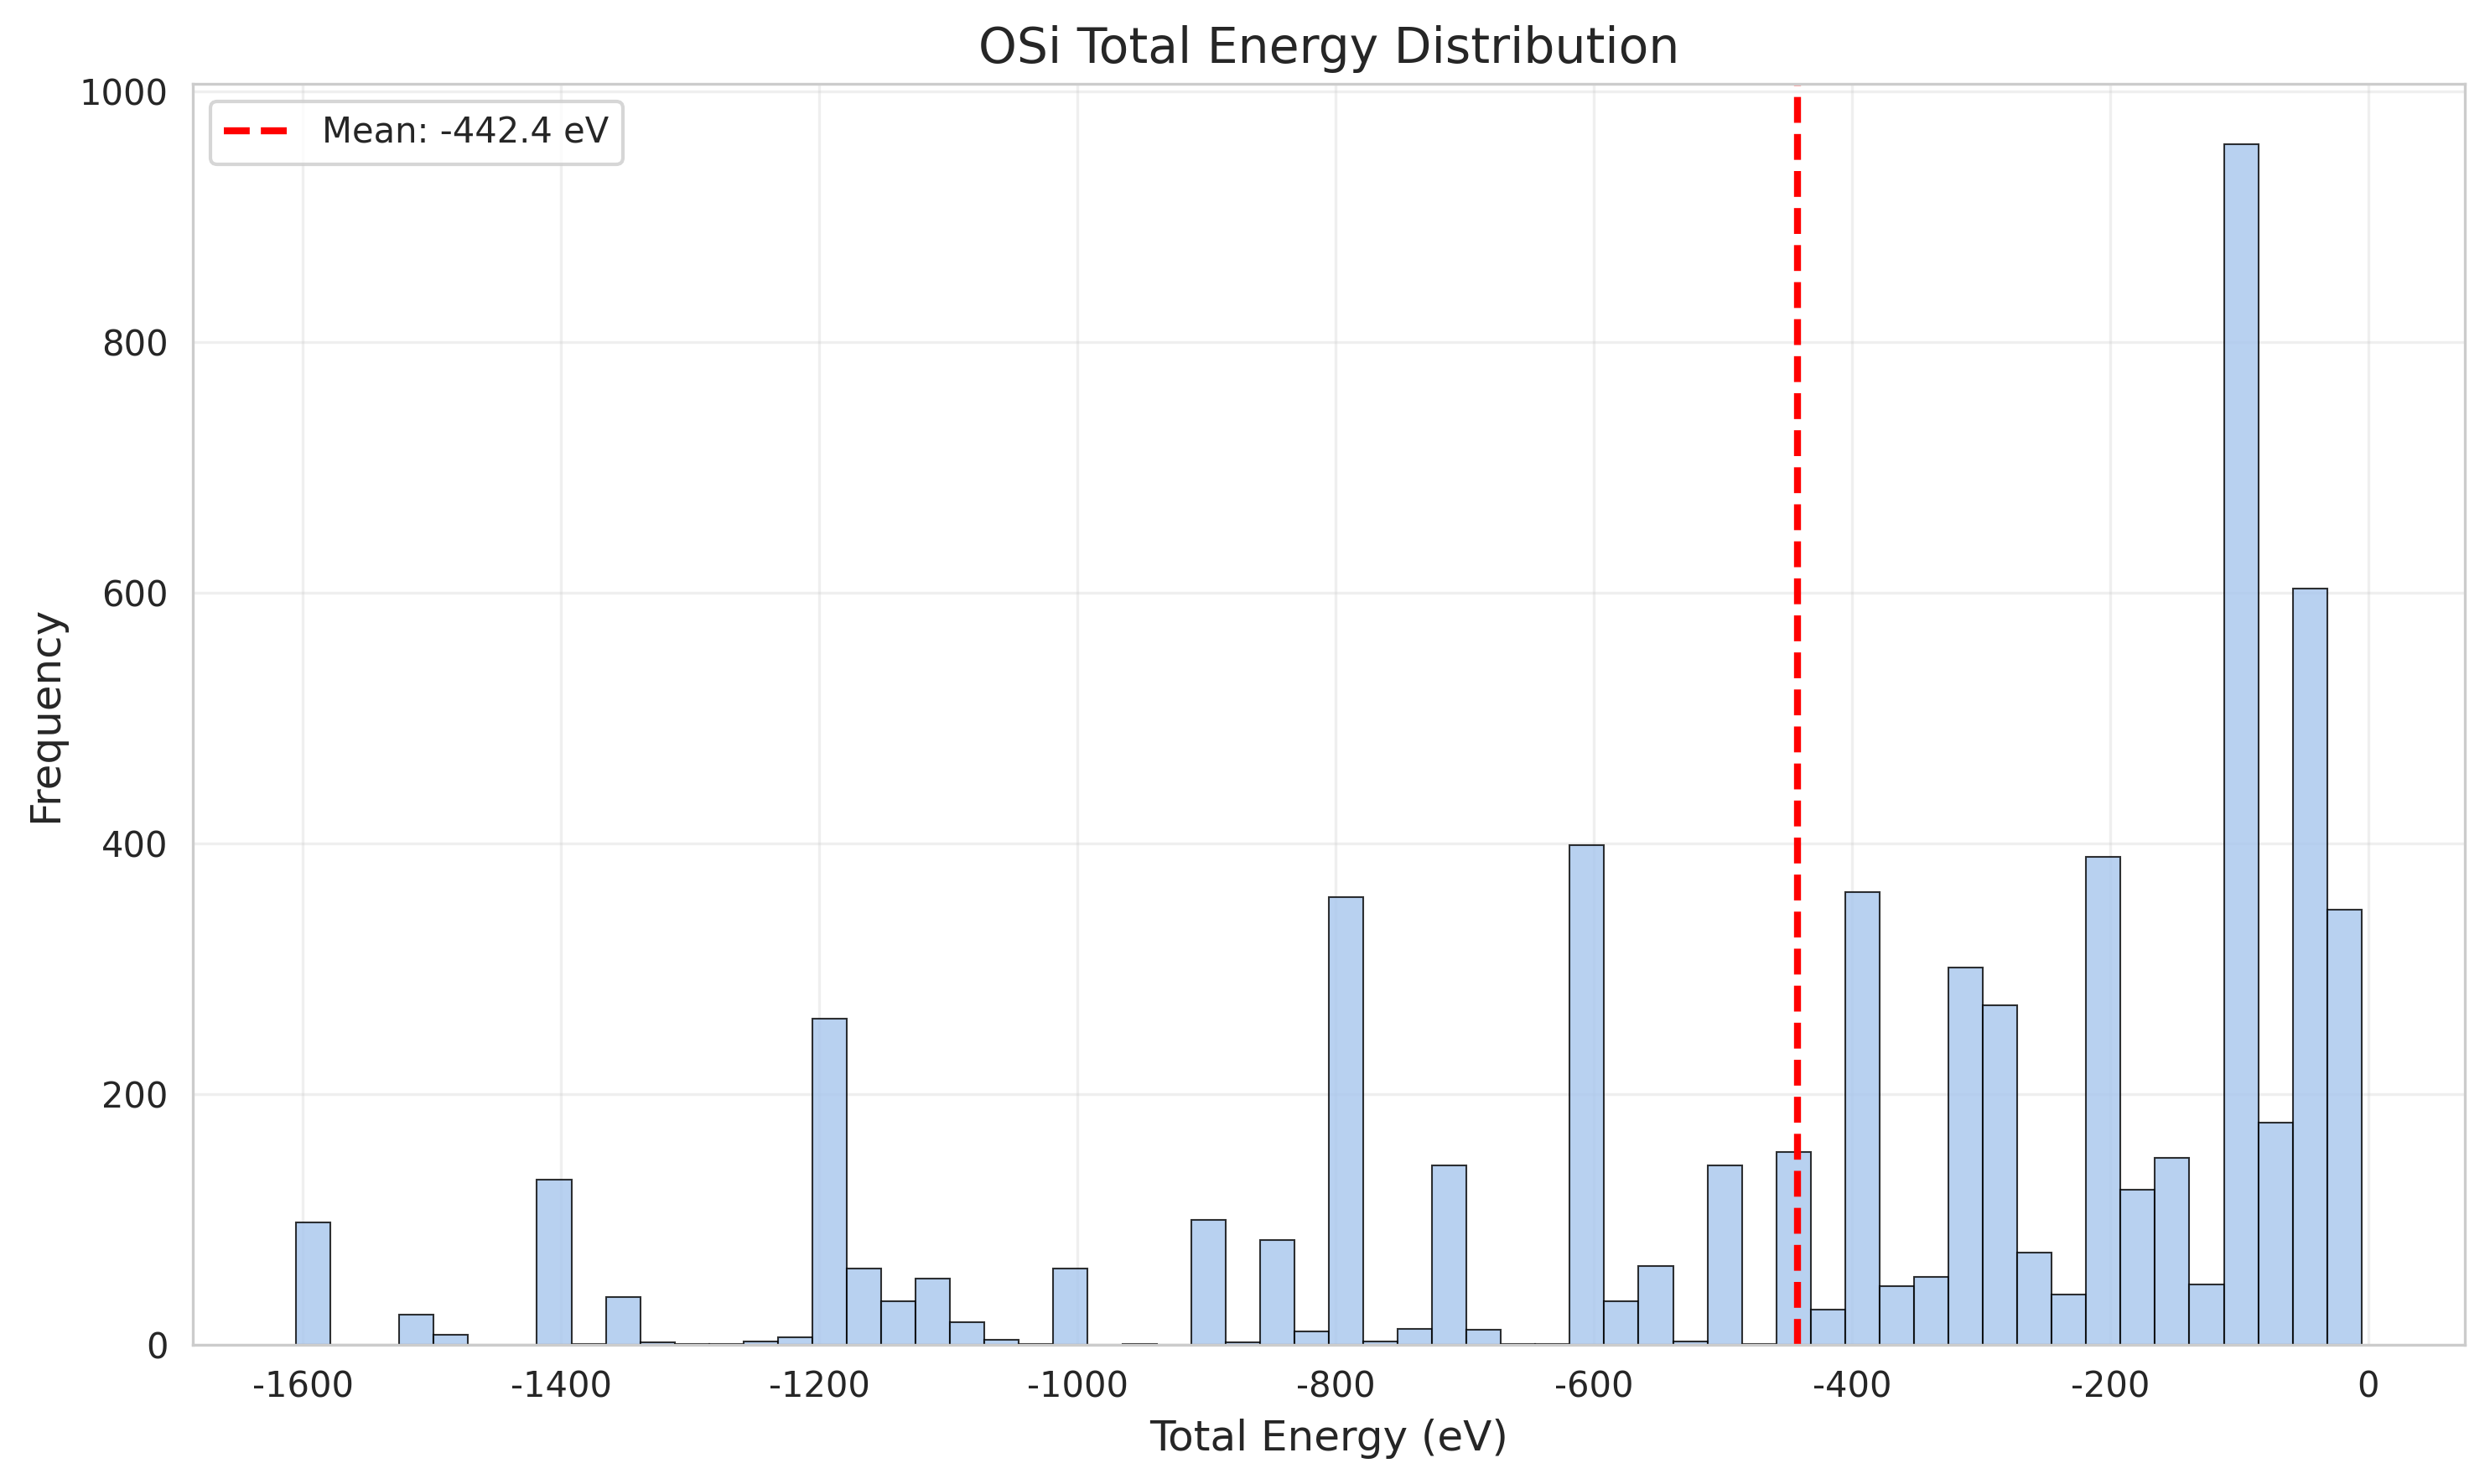

✓ 能量分布图已生成


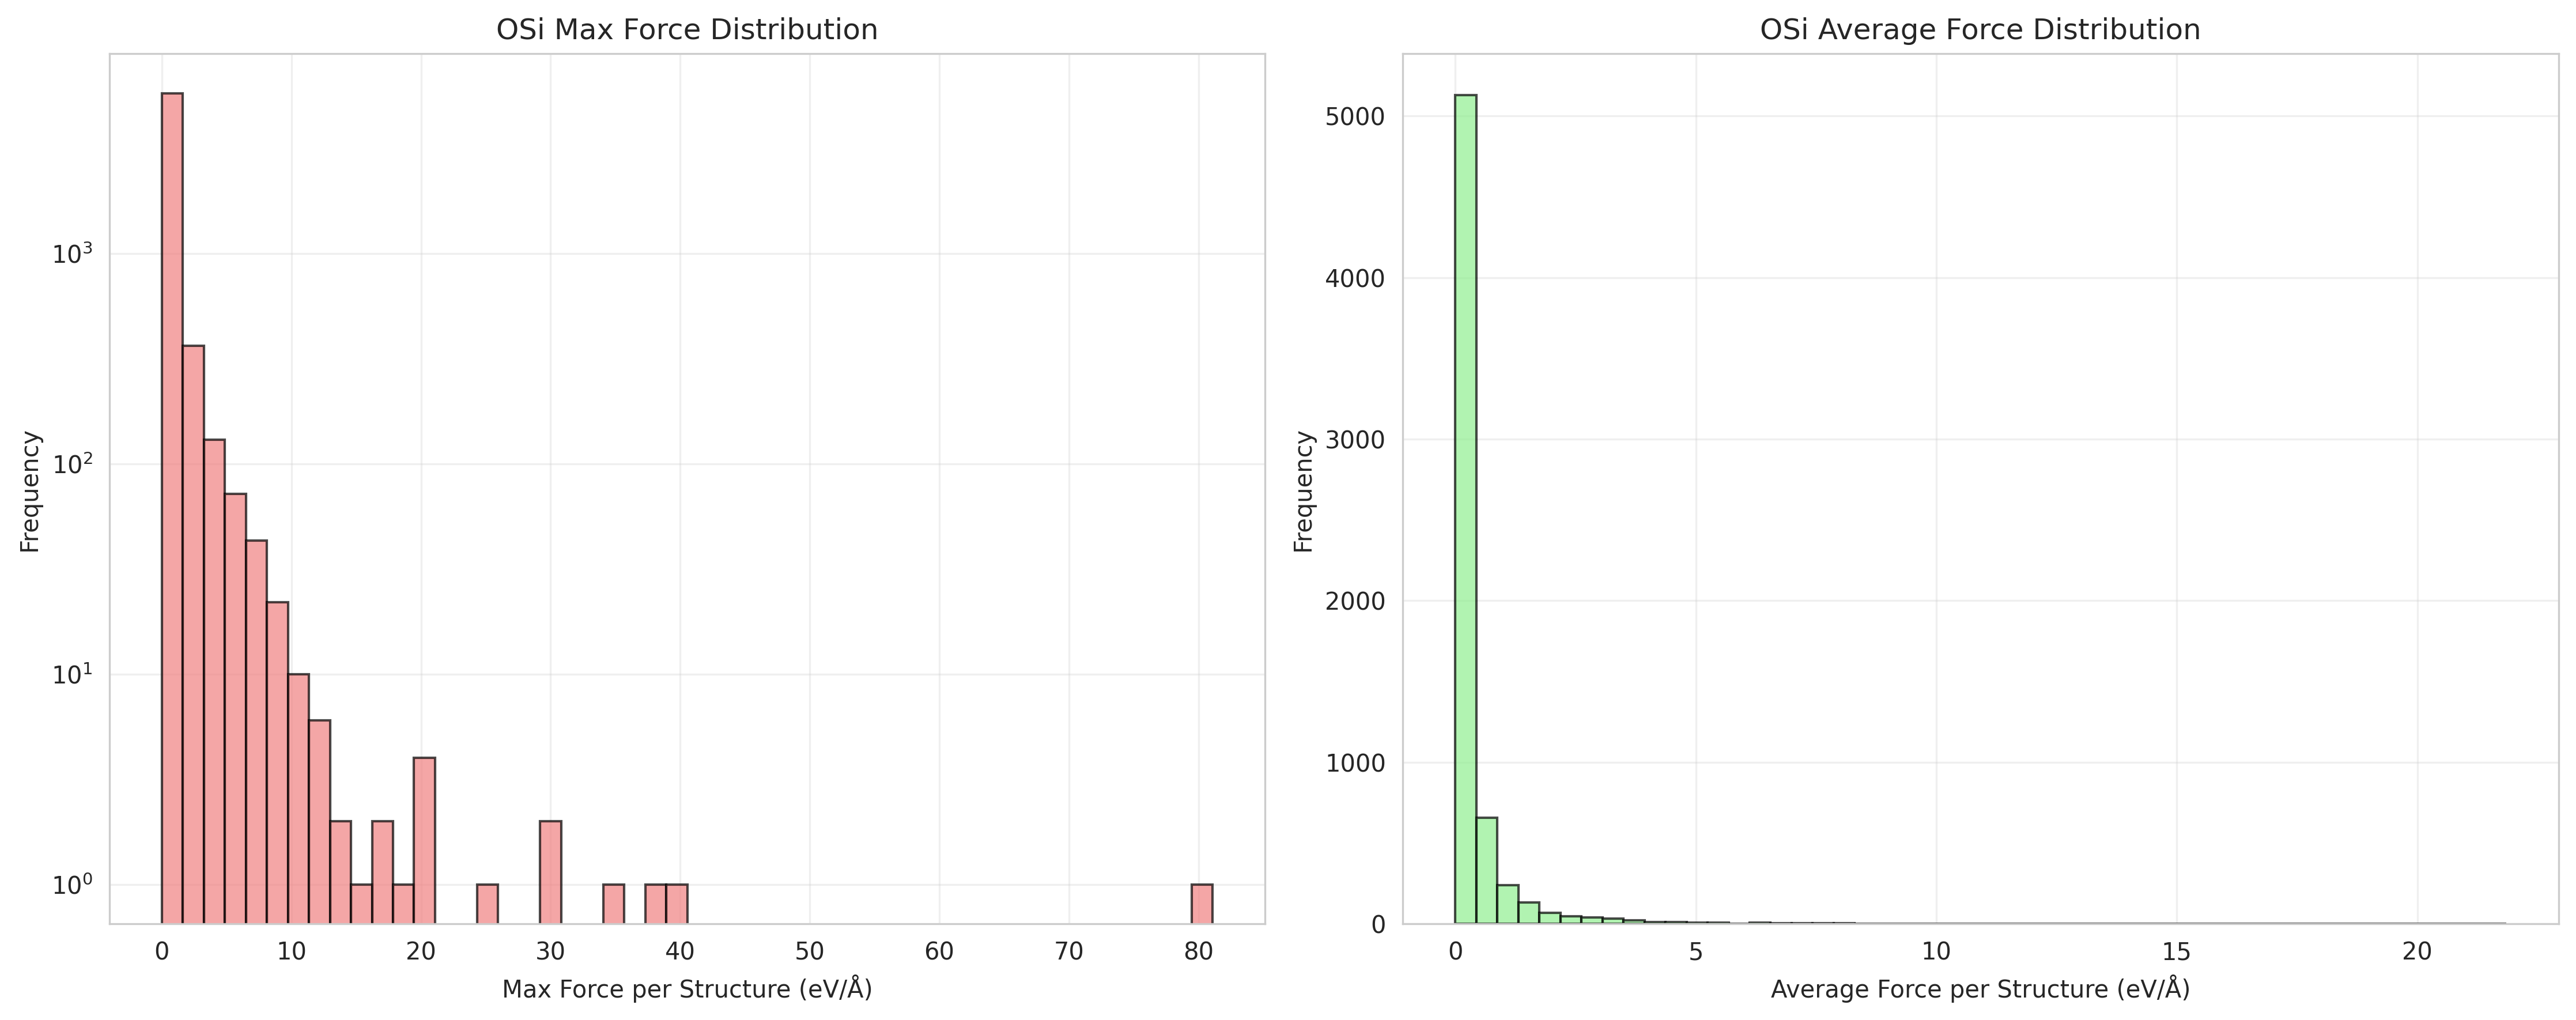

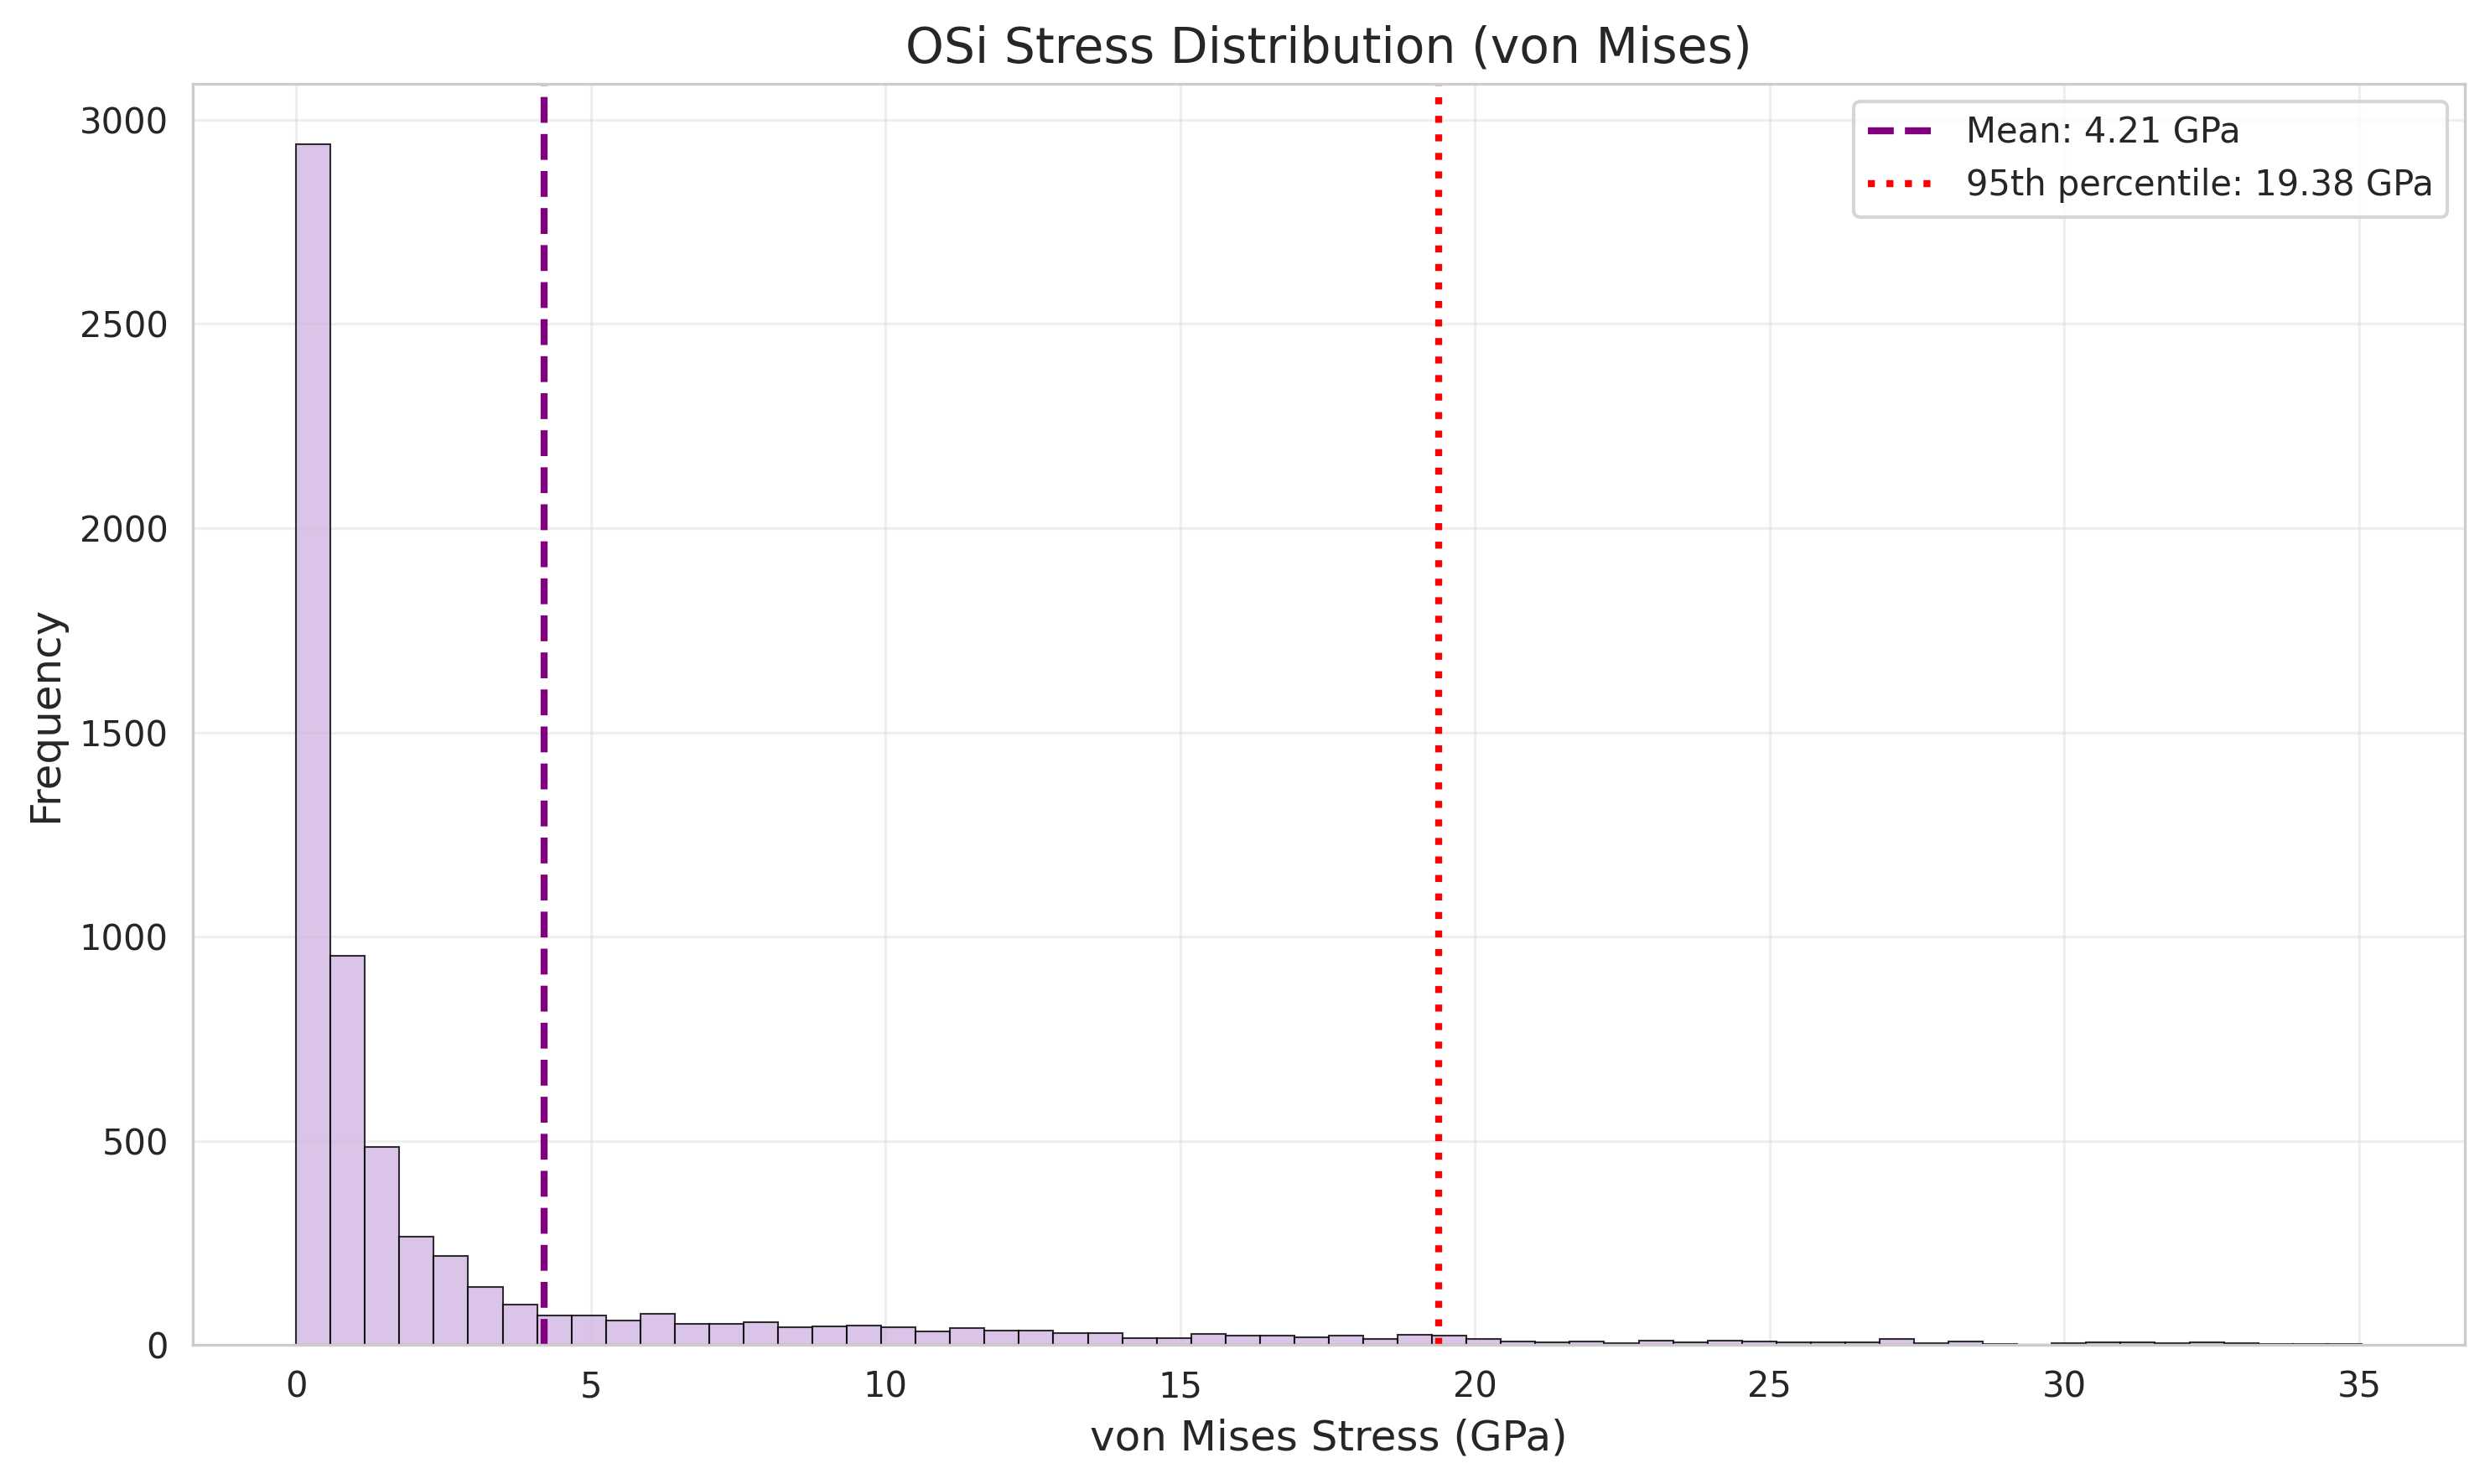

✓ 应力分布图已生成


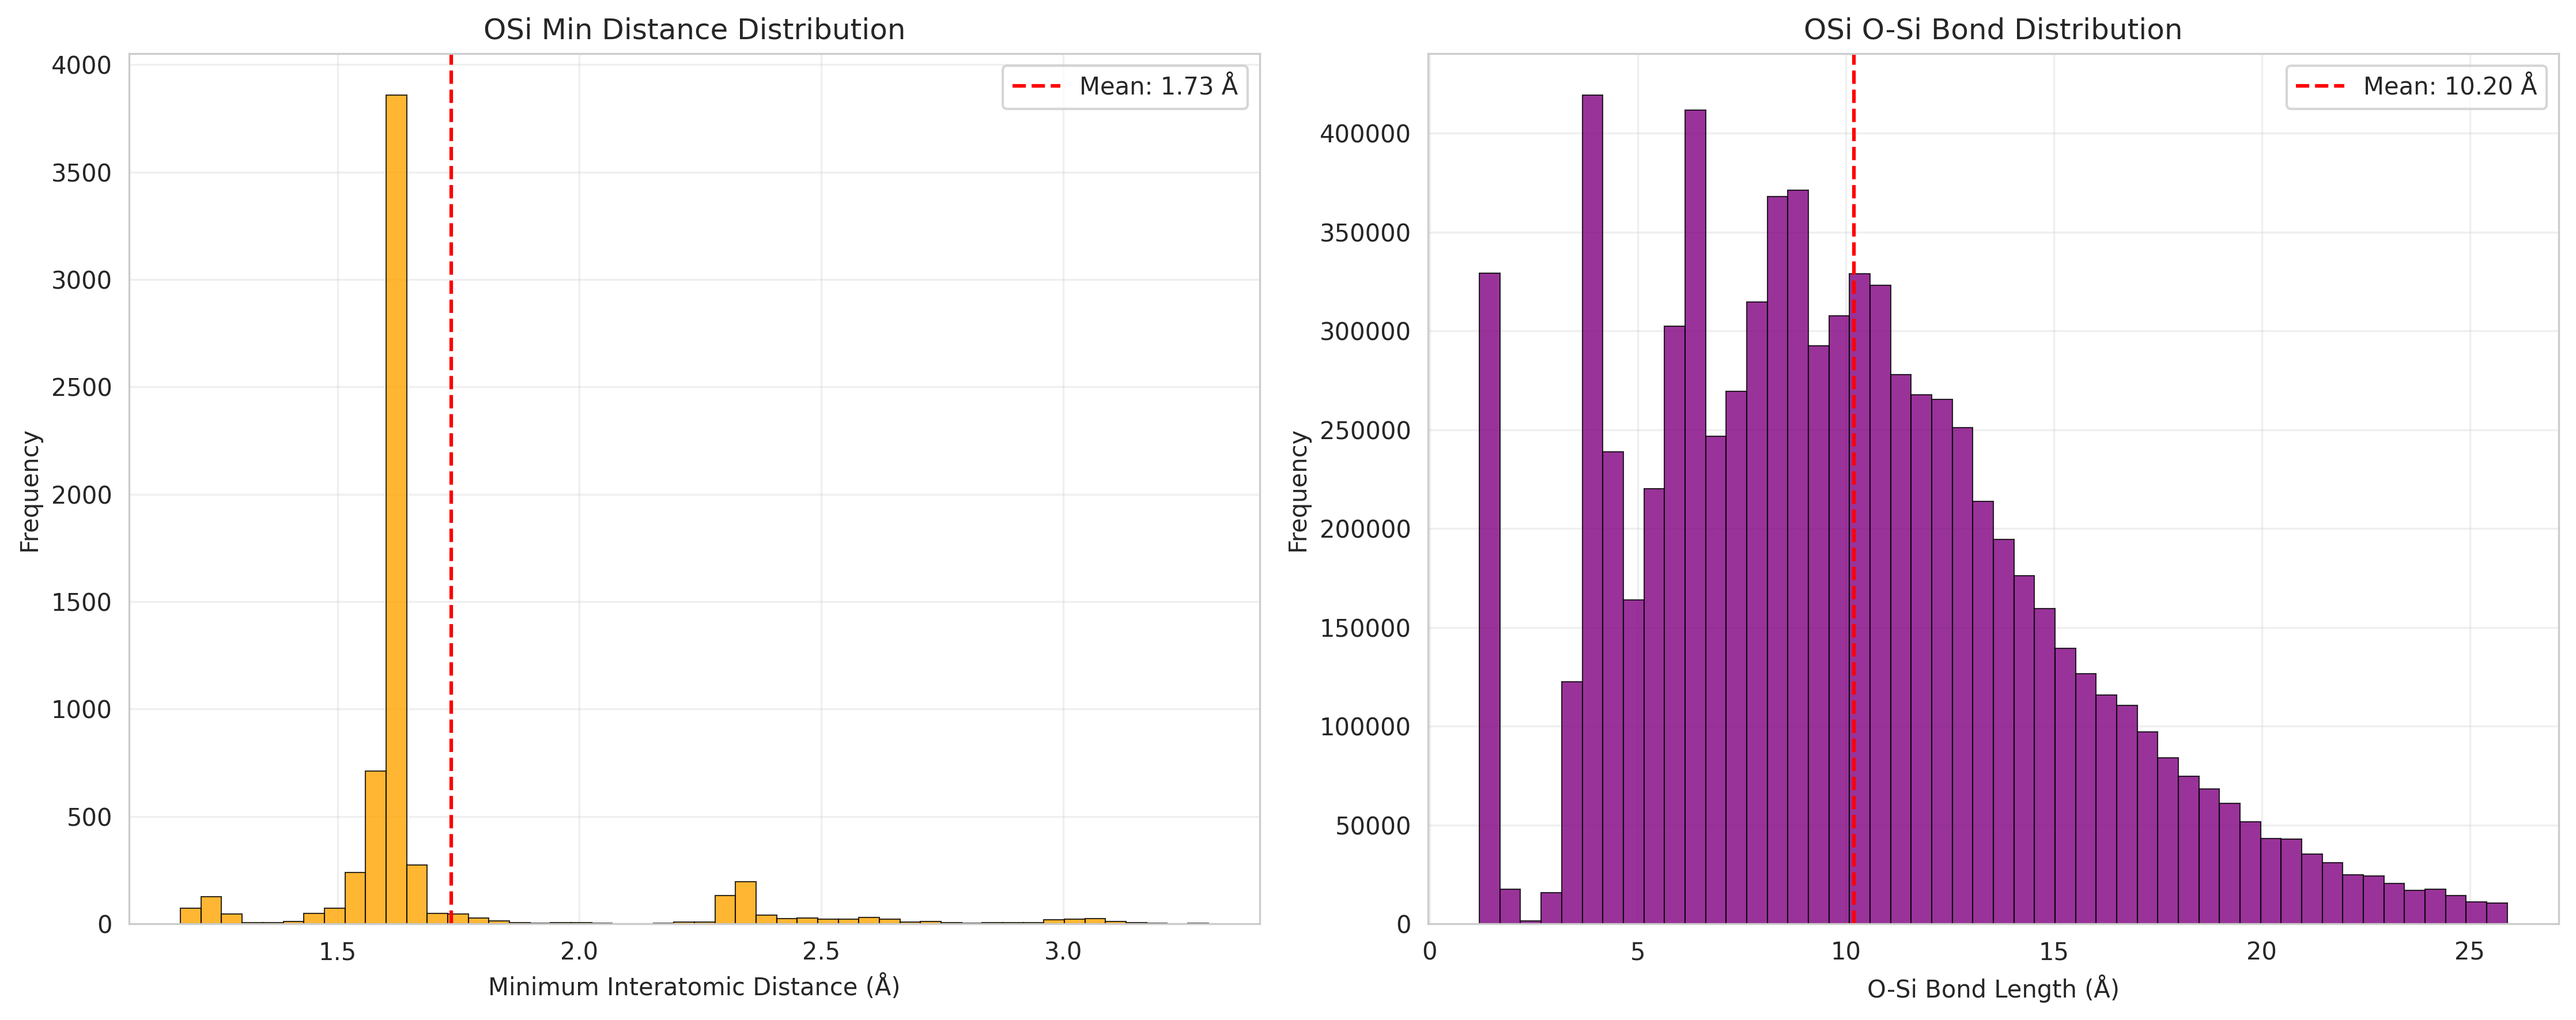

✓ 几何分布图已生成
分布图已保存到: OSi/original/distributions

=== 第二步分析完成 ===
分布图保存在: OSi/original/distributions
统计报告保存在: OSi/original/distribution_analysis.txt

第二步完成! 请查看生成的分布图和统计报告。


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time

# 设置中文字体和绘图风格
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

def parse_structure_data(structure):
    """
    解析单个结构的详细数据
    """
    properties = structure['properties']
    species = structure['species']
    atoms_data = structure['atoms']
    
    # 解析能量
    energy = None
    if 'REF_energy' in properties:
        try:
            energy = float(properties['REF_energy'])
        except Exception as e:
            print(f"能量解析错误: {e}, 值: {properties['REF_energy']}")
            energy = None
    
    # 解析应力张量
    stress_tensor = None
    if 'REF_stress' in properties:
        try:
            stress_str = properties['REF_stress'].strip('"')
            stress_values = [float(x) for x in stress_str.split()]
            if len(stress_values) >= 6:
                # 应力张量：xx, yy, zz, xy, xz, yz
                stress_tensor = {
                    'xx': stress_values[0], 'yy': stress_values[1], 'zz': stress_values[2],
                    'xy': stress_values[3], 'xz': stress_values[4], 'yz': stress_values[5]
                }
        except Exception as e:
            print(f"应力解析错误: {e}")
            stress_tensor = None
    
    # 解析原子坐标和力
    positions = []
    forces = []
    for atom_line in atoms_data:
        parts = atom_line.split()
        if len(parts) >= 7:  # 元素 + 3坐标 + 3力
            try:
                pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                force = [float(parts[4]), float(parts[5]), float(parts[6])]
                positions.append(pos)
                forces.append(force)
            except:
                continue
    
    # 计算力的统计量
    force_magnitudes = []
    if forces:
        for force in forces:
            magnitude = np.sqrt(sum(f**2 for f in force))
            force_magnitudes.append(magnitude)
    
    # 计算几何特征
    geometry_stats = calculate_geometry_features(species, positions)
    
    return {
        'energy': energy,
        'energy_per_atom': energy / len(species) if energy and len(species) > 0 else None,
        'stress_tensor': stress_tensor,
        'forces': forces,
        'force_magnitudes': force_magnitudes,
        'max_force': max(force_magnitudes) if force_magnitudes else None,
        'avg_force': np.mean(force_magnitudes) if force_magnitudes else None,
        'positions': positions,
        'geometry': geometry_stats,
        'n_atoms': len(species),
        'composition': Counter(species)
    }

def calculate_geometry_features(species, positions):
    """
    计算几何特征：键长、原子间距等
    """
    if len(positions) < 2:
        return {'min_distance': None, 'bond_lengths': {}}
    
    positions = np.array(positions)
    n_atoms = len(positions)
    
    # 计算所有原子间距离
    distances = []
    bond_lengths = {}
    
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            dist = np.linalg.norm(positions[i] - positions[j])
            distances.append(dist)
            
            # 记录特定元素对的键长
            pair = tuple(sorted([species[i], species[j]]))
            if pair not in bond_lengths:
                bond_lengths[pair] = []
            bond_lengths[pair].append(dist)
    
    return {
        'min_distance': min(distances) if distances else None,
        'avg_distance': np.mean(distances) if distances else None,
        'bond_lengths': bond_lengths,
        'all_distances': distances
    }

def analyze_filtered_data(extxyz_file):
    """
    分析筛选后的数据，提取所有特征用于分布分析
    """
    print(f"=== 第二步：数据分布分析 ===")
    print(f"分析文件: {extxyz_file}")
    
    if not os.path.exists(extxyz_file):
        raise FileNotFoundError(f"文件不存在: {extxyz_file}")
    
    # 先用你的方法直接提取能量和应力数据
    print("使用直接方法提取能量和应力...")
    energies = []
    stress_data = []
    
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        for line in f:
            # 提取能量
            if "REF_energy=" in line:
                for part in line.strip().split():
                    if part.startswith("REF_energy="):
                        try:
                            energy = float(part.split("=")[1])
                            energies.append(energy)
                            break
                        except:
                            pass
            
            # 提取应力
            if "REF_stress=" in line:
                try:
                    # 使用正则表达式提取引号内的应力数据
                    stress_match = re.search(r'REF_stress="([^"]*)"', line)
                    if stress_match:
                        stress_str = stress_match.group(1)
                        stress_values = [float(x) for x in stress_str.split()]
                        if len(stress_values) >= 6:
                            stress_data.append(stress_values)
                except:
                    pass
    
    print(f"直接方法提取结果: {len(energies)} 个能量值, {len(stress_data)} 个应力张量")
    
    # 提取所有原子的力数据（参考你的force代码）
    print("提取原子力数据...")
    all_force_magnitudes = []
    
    # 存储所有分析数据
    analysis_data = {
        'energies': energies,  # 保存总能量
        'energies_per_atom': [],  # 也保留每原子能量以备用
        'all_force_magnitudes': [],  # 所有原子的力
        'max_forces': [],  # 每个结构的最大力
        'avg_forces': [],  # 每个结构的平均力
        'stress_xx': [s[0] for s in stress_data] if stress_data else [],
        'stress_yy': [s[1] for s in stress_data] if stress_data else [],
        'stress_zz': [s[2] for s in stress_data] if stress_data else [],
        'stress_xy': [s[3] for s in stress_data] if stress_data else [],
        'stress_xz': [s[4] for s in stress_data] if stress_data else [],
        'stress_yz': [s[5] for s in stress_data] if stress_data else [],
        'min_distances': [],
        'bond_lengths': {},
        'compositions': [],
        'n_atoms_list': []
    }
    
    structures_count = 0
    start_time = time.time()
    
    # 现在按结构解析来获取其他信息（力、几何等）
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        while True:
            # 读取头部
            header_line = f.readline()
            if not header_line:
                break
            
            try:
                # 解析头部获取原子数
                n_atoms = int(header_line.strip().split()[0])
                
                # 获取对应的能量（如果有）
                current_energy = None
                if structures_count < len(energies):
                    current_energy = energies[structures_count]
                    # 计算每原子能量
                    energy_per_atom = current_energy / n_atoms if current_energy else None
                    if energy_per_atom:
                        analysis_data['energies_per_atom'].append(energy_per_atom)
                
                # 读取注释行
                comment_line = f.readline()
                
                # 读取原子数据并提取力
                atoms_data = []
                species = []
                structure_forces = []
                
                for _ in range(n_atoms):
                    atom_line = f.readline().strip()
                    if atom_line:
                        atoms_data.append(atom_line)
                        parts = atom_line.split()
                        if len(parts) >= 7:  # 元素 + 3坐标 + 3力
                            species.append(parts[0])
                            try:
                                # 提取力的三个分量
                                fx, fy, fz = float(parts[4]), float(parts[5]), float(parts[6])
                                force_magnitude = np.sqrt(fx**2 + fy**2 + fz**2)
                                structure_forces.append(force_magnitude)
                                all_force_magnitudes.append(force_magnitude)
                            except:
                                pass
                        else:
                            species.append(parts[0] if parts else 'X')
                
                # 计算这个结构的力统计
                if structure_forces:
                    analysis_data['max_forces'].append(max(structure_forces))
                    analysis_data['avg_forces'].append(np.mean(structure_forces))
                
                # 构建结构数据（仅用于解析几何）
                structure = {
                    'properties': {},  # 不需要重复解析
                    'species': species,
                    'atoms': atoms_data
                }
                
                # 解析几何特征
                positions = []
                for atom_line in atoms_data:
                    parts = atom_line.split()
                    if len(parts) >= 4:  # 至少有坐标
                        try:
                            pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                            positions.append(pos)
                        except:
                            continue
                
                # 计算几何特征
                if len(positions) >= 2:
                    geometry_stats = calculate_geometry_features(species, positions)
                    if geometry_stats['min_distance']:
                        analysis_data['min_distances'].append(geometry_stats['min_distance'])
                    
                    # 键长数据
                    for bond_type, lengths in geometry_stats['bond_lengths'].items():
                        if bond_type not in analysis_data['bond_lengths']:
                            analysis_data['bond_lengths'][bond_type] = []
                        analysis_data['bond_lengths'][bond_type].extend(lengths)
                
                analysis_data['n_atoms_list'].append(len(species))
                analysis_data['compositions'].append(Counter(species))
                
                structures_count += 1
                
                if structures_count % 1000 == 0:
                    elapsed = time.time() - start_time
                    print(f"已分析: {structures_count:,} 个结构, 用时: {elapsed:.1f}s")
                    
            except Exception as e:
                print(f"分析第 {structures_count+1} 个结构时出错: {e}")
                continue
    
    # 保存所有原子的力数据
    analysis_data['all_force_magnitudes'] = all_force_magnitudes
    
    print(f"分析完成: 共 {structures_count:,} 个结构")
    print(f"提取到 {len(all_force_magnitudes):,} 个原子的力数据")
    return analysis_data

def create_distribution_plots(analysis_data, element_system, save_dir):
    """
    创建数据分布图
    """
    print("生成分布图...")
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 调试信息：检查数据状态
    print(f"调试信息:")
    print(f"  总能量数据数量: {len(analysis_data['energies'])}")
    print(f"  原子力数据数量: {len(analysis_data['all_force_magnitudes'])}")
    print(f"  结构最大力数据数量: {len(analysis_data['max_forces'])}")
    print(f"  应力数据数量: {len(analysis_data['stress_xx'])}")
    print(f"  几何数据数量: {len(analysis_data['min_distances'])}")
    
    # 1. 能量分布图 - 只要直方图，去掉箱线图
    if analysis_data['energies']:
        plt.figure(figsize=(10, 6))
        
        energies = np.array(analysis_data['energies'])
        
        # 计算合理的显示范围（去掉极端异常值）
        q1, q99 = np.percentile(energies, [1, 99])
        mask = (energies >= q1) & (energies <= q99)
        energies_filtered = energies[mask]
        
        plt.hist(energies_filtered, bins=60, alpha=0.8, color='#A7C6ED', edgecolor='black', linewidth=0.5)
        plt.xlabel('Total Energy (eV)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'{element_system} Total Energy Distribution', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_e = np.mean(energies)
        plt.axvline(mean_e, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_e:.1f} eV')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'energy_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ 能量分布图已生成")
    else:
        print("⚠️  警告: 没有找到能量数据，跳过能量分布图")
    
    # 2. 力分布图
    if analysis_data['max_forces']:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        max_forces = np.array(analysis_data['max_forces'])
        avg_forces = np.array(analysis_data['avg_forces'])
        
        # 最大力分布
        ax1.hist(max_forces, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        ax1.set_xlabel('Max Force per Structure (eV/Å)')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'{element_system} Max Force Distribution')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        # 平均力分布
        ax2.hist(avg_forces, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        ax2.set_xlabel('Average Force per Structure (eV/Å)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'{element_system} Average Force Distribution')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'force_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. 应力分布图 - 转换为标量
    if any(analysis_data[comp] for comp in ['stress_xx', 'stress_yy', 'stress_zz']):
        plt.figure(figsize=(10, 6))
        
        # 计算应力标量（von Mises等效应力或Frobenius范数）
        stress_scalars = []
        for i in range(len(analysis_data['stress_xx'])):
            # 获取应力张量的对角线元素
            sxx = analysis_data['stress_xx'][i]
            syy = analysis_data['stress_yy'][i] 
            szz = analysis_data['stress_zz'][i]
            sxy = analysis_data['stress_xy'][i] if analysis_data['stress_xy'] else 0
            sxz = analysis_data['stress_xz'][i] if analysis_data['stress_xz'] else 0
            syz = analysis_data['stress_yz'][i] if analysis_data['stress_yz'] else 0
            
            # 计算von Mises等效应力
            von_mises = np.sqrt(0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2 + 
                                      6 * (sxy**2 + sxz**2 + syz**2)))
            stress_scalars.append(von_mises)
        
        stress_scalars = np.array(stress_scalars)
        
        # 设置合理的显示范围
        stress_limit = np.percentile(stress_scalars, 98)
        mask = stress_scalars <= stress_limit
        stress_filtered = stress_scalars[mask]
        
        plt.hist(stress_filtered, bins=60, alpha=0.8, color='#D1B6E1', edgecolor='black', linewidth=0.5)
        plt.xlabel('von Mises Stress (GPa)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'{element_system} Stress Distribution (von Mises)', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # 添加统计线
        mean_stress = np.mean(stress_scalars)
        p95_stress = np.percentile(stress_scalars, 95)
        plt.axvline(mean_stress, color='purple', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_stress:.2f} GPa')
        plt.axvline(p95_stress, color='red', linestyle=':', linewidth=2,
                   label=f'95th percentile: {p95_stress:.2f} GPa')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'stress_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ 应力分布图已生成")
    else:
        print("⚠️  警告: 没有找到应力数据，跳过应力分布图")
    
    # 4. 几何特征分布图 - 简化为2个关键图
    if analysis_data['bond_lengths'] or analysis_data['min_distances']:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 左图：最小原子间距
        if analysis_data['min_distances']:
            min_dists = np.array(analysis_data['min_distances'])
            # 设置合理范围
            dist_limit = np.percentile(min_dists, 99)
            mask = min_dists <= dist_limit
            dists_filtered = min_dists[mask]
            
            axes[0].hist(dists_filtered, bins=50, alpha=0.8, color='orange', edgecolor='black', linewidth=0.5)
            axes[0].set_xlabel('Minimum Interatomic Distance (Å)')
            axes[0].set_ylabel('Frequency')
            axes[0].set_title(f'{element_system} Min Distance Distribution')
            axes[0].grid(True, alpha=0.3)
            
            # 添加统计线
            mean_dist = np.mean(min_dists)
            axes[0].axvline(mean_dist, color='red', linestyle='--', 
                           label=f'Mean: {mean_dist:.2f} Å')
            axes[0].legend()
        
        # 右图：主要键长分布（选择样本数最多的键型）
        if analysis_data['bond_lengths']:
            # 找到样本数最多的键型
            main_bond = max(analysis_data['bond_lengths'].items(), key=lambda x: len(x[1]))
            bond_type, bond_lengths = main_bond
            
            if len(bond_lengths) > 100:  # 只有足够样本才显示
                bond_lengths = np.array(bond_lengths)
                bond_limit = np.percentile(bond_lengths, 99)
                mask = bond_lengths <= bond_limit
                bonds_filtered = bond_lengths[mask]
                
                axes[1].hist(bonds_filtered, bins=50, alpha=0.8, color='purple', 
                           edgecolor='black', linewidth=0.5)
                axes[1].set_xlabel(f'{bond_type[0]}-{bond_type[1]} Bond Length (Å)')
                axes[1].set_ylabel('Frequency')
                axes[1].set_title(f'{element_system} {bond_type[0]}-{bond_type[1]} Bond Distribution')
                axes[1].grid(True, alpha=0.3)
                
                # 添加统计线
                mean_bond = np.mean(bond_lengths)
                axes[1].axvline(mean_bond, color='red', linestyle='--',
                               label=f'Mean: {mean_bond:.2f} Å')
                axes[1].legend()
            else:
                axes[1].text(0.5, 0.5, 'No sufficient bond data', 
                           transform=axes[1].transAxes, ha='center', va='center')
                axes[1].set_title('Bond Length Distribution')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'geometry_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ 几何分布图已生成")
    
    print(f"分布图已保存到: {save_dir}")

def generate_statistics_summary(analysis_data, element_system, save_file):
    """
    生成详细的统计摘要
    """
    with open(save_file, 'w', encoding='utf-8') as f:
        f.write(f"=== {element_system} 体系数据分布分析报告 ===\n")
        f.write(f"分析时间: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # 能量统计
        if analysis_data['energies_per_atom']:
            energies = np.array(analysis_data['energies_per_atom'])
            f.write("【能量统计】\n")
            f.write(f"  样本数量: {len(energies):,}\n")
            f.write(f"  平均值: {np.mean(energies):.6f} eV/atom\n")
            f.write(f"  标准差: {np.std(energies):.6f} eV/atom\n")
            f.write(f"  最小值: {np.min(energies):.6f} eV/atom\n")
            f.write(f"  最大值: {np.max(energies):.6f} eV/atom\n")
            f.write(f"  建议3σ范围: [{np.mean(energies) - 3*np.std(energies):.6f}, {np.mean(energies) + 3*np.std(energies):.6f}] eV/atom\n\n")
        
        # 力统计
        if analysis_data['max_forces']:
            max_forces = np.array(analysis_data['max_forces'])
            avg_forces = np.array(analysis_data['avg_forces'])
            f.write("【力统计】\n")
            f.write(f"  最大力统计:\n")
            f.write(f"    平均值: {np.mean(max_forces):.4f} eV/Å\n")
            f.write(f"    标准差: {np.std(max_forces):.4f} eV/Å\n")
            f.write(f"    95分位数: {np.percentile(max_forces, 95):.4f} eV/Å\n")
            f.write(f"    99分位数: {np.percentile(max_forces, 99):.4f} eV/Å\n")
            f.write(f"  建议最大力阈值: {np.percentile(max_forces, 95):.2f} eV/Å\n\n")
        
        # 应力统计
        stress_components = ['stress_xx', 'stress_yy', 'stress_zz', 'stress_xy', 'stress_xz', 'stress_yz']
        if any(analysis_data[comp] for comp in stress_components):
            f.write("【应力统计】\n")
            for comp in stress_components:
                if analysis_data[comp]:
                    stress_data = np.array(analysis_data[comp])
                    f.write(f"  {comp}:\n")
                    f.write(f"    平均值: {np.mean(stress_data):.6f} GPa\n")
                    f.write(f"    标准差: {np.std(stress_data):.6f} GPa\n")
                    f.write(f"    范围: [{np.min(stress_data):.6f}, {np.max(stress_data):.6f}] GPa\n")
            f.write("\n")
        
        # 几何统计
        if analysis_data['min_distances']:
            min_dists = np.array(analysis_data['min_distances'])
            f.write("【几何特征统计】\n")
            f.write(f"  最小原子间距:\n")
            f.write(f"    平均值: {np.mean(min_dists):.4f} Å\n")
            f.write(f"    最小值: {np.min(min_dists):.4f} Å\n")
            f.write(f"    5分位数: {np.percentile(min_dists, 5):.4f} Å\n")
            f.write(f"  建议最小距离阈值: {np.percentile(min_dists, 5):.2f} Å\n\n")
        
        # 键长统计
        if analysis_data['bond_lengths']:
            f.write("【键长分布统计】\n")
            for bond_type, lengths in analysis_data['bond_lengths'].items():
                if len(lengths) > 10:  # 只显示样本数足够的键型
                    lengths_array = np.array(lengths)
                    f.write(f"  {bond_type[0]}-{bond_type[1]} 键:\n")
                    f.write(f"    样本数: {len(lengths):,}\n")
                    f.write(f"    平均键长: {np.mean(lengths_array):.4f} Å\n")
                    f.write(f"    标准差: {np.std(lengths_array):.4f} Å\n")
                    f.write(f"    范围: [{np.min(lengths_array):.4f}, {np.max(lengths_array):.4f}] Å\n")
            f.write("\n")
        
        # 建议的筛选阈值
        f.write("【建议的筛选阈值】\n")
        if analysis_data['energies_per_atom']:
            energies = np.array(analysis_data['energies_per_atom'])
            f.write(f"  能量筛选(3σ): [{np.mean(energies) - 3*np.std(energies):.6f}, {np.mean(energies) + 3*np.std(energies):.6f}] eV/atom\n")
        if analysis_data['max_forces']:
            f.write(f"  最大力阈值: {np.percentile(np.array(analysis_data['max_forces']), 95):.2f} eV/Å\n")
        if analysis_data['min_distances']:
            f.write(f"  最小距离阈值: {np.percentile(np.array(analysis_data['min_distances']), 5):.2f} Å\n")

def step2_analyze_data(extxyz_file):
    """
    第二步主函数：数据分布分析
    
    参数:
    extxyz_file: 第一步输出的筛选数据文件路径
    
    返回:
    analysis_data: 分析数据
    statistics_file: 统计报告文件路径
    """
    # 确定元素体系和保存路径
    base_dir = os.path.dirname(os.path.dirname(extxyz_file))  # 去掉/original部分
    element_system = os.path.basename(base_dir)
    distributions_dir = os.path.join(os.path.dirname(extxyz_file), 'distributions')
    
    try:
        # 分析数据
        analysis_data = analyze_filtered_data(extxyz_file)
        
        # 生成分布图
        create_distribution_plots(analysis_data, element_system, distributions_dir)
        
        # 生成统计报告
        stats_file = os.path.join(os.path.dirname(extxyz_file), 'distribution_analysis.txt')
        generate_statistics_summary(analysis_data, element_system, stats_file)
        
        print(f"\n=== 第二步分析完成 ===")
        print(f"分布图保存在: {distributions_dir}")
        print(f"统计报告保存在: {stats_file}")
        
        return analysis_data, stats_file
        
    except Exception as e:
        print(f"第二步分析过程中出现错误: {e}")
        raise

# 使用示例
if __name__ == "__main__":
    # 示例调用（假设第一步已完成）
    extxyz_file = "OSi/original/OSi_original.extxyz"  # 第一步的输出文件
    
    analysis_data, stats_file = step2_analyze_data(extxyz_file)
    print(f"\n第二步完成! 请查看生成的分布图和统计报告。")

# 第三步-数据筛选

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
import re

def quick_analyze_for_thresholds(extxyz_file):
    """
    快速分析数据以生成筛选阈值（不需要导入第二步模块）
    """
    print("快速分析数据以生成筛选阈值...")
    
    energies = []
    all_forces = []
    stress_data = []
    min_distances = []
    
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        structure_count = 0
        
        while True:
            header_line = f.readline()
            if not header_line:
                break
                
            try:
                n_atoms = int(header_line.strip().split()[0])
                
                # 提取能量
                if 'REF_energy=' in header_line:
                    for part in header_line.strip().split():
                        if part.startswith("REF_energy="):
                            try:
                                energy = float(part.split("=")[1])
                                energies.append(energy)
                                break
                            except:
                                pass
                
                # 提取应力
                if 'REF_stress=' in header_line:
                    try:
                        stress_match = re.search(r'REF_stress="([^"]*)"', header_line)
                        if stress_match:
                            stress_str = stress_match.group(1)
                            stress_values = [float(x) for x in stress_str.split()]
                            if len(stress_values) >= 6:
                                stress_data.append(stress_values)
                    except:
                        pass
                
                # 读取注释行
                comment_line = f.readline()
                
                # 读取原子数据，提取力和坐标
                positions = []
                structure_forces = []
                
                for _ in range(n_atoms):
                    atom_line = f.readline().strip()
                    if atom_line:
                        parts = atom_line.split()
                        if len(parts) >= 7:
                            try:
                                # 坐标
                                pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                                positions.append(pos)
                                
                                # 力
                                fx, fy, fz = float(parts[4]), float(parts[5]), float(parts[6])
                                force_mag = np.sqrt(fx**2 + fy**2 + fz**2)
                                structure_forces.append(force_mag)
                                all_forces.append(force_mag)
                            except:
                                pass
                
                # 计算最小原子间距
                if len(positions) >= 2:
                    min_dist = float('inf')
                    positions_array = np.array(positions)
                    for i in range(len(positions_array)):
                        for j in range(i+1, len(positions_array)):
                            dist = np.linalg.norm(positions_array[i] - positions_array[j])
                            min_dist = min(min_dist, dist)
                    if min_dist != float('inf'):
                        min_distances.append(min_dist)
                
                structure_count += 1
                
                if structure_count % 1000 == 0:
                    print(f"已分析: {structure_count:,} 个结构")
                    
            except Exception as e:
                continue
    
    print(f"分析完成: 共 {structure_count:,} 个结构")
    
    # 构建分析数据
    analysis_data = {
        'energies': energies,
        'all_force_magnitudes': all_forces,
        'stress_xx': [s[0] for s in stress_data] if stress_data else [],
        'stress_yy': [s[1] for s in stress_data] if stress_data else [],
        'stress_zz': [s[2] for s in stress_data] if stress_data else [],
        'stress_xy': [s[3] for s in stress_data] if stress_data else [],
        'stress_xz': [s[4] for s in stress_data] if stress_data else [],
        'stress_yz': [s[5] for s in stress_data] if stress_data else [],
        'min_distances': min_distances
    }
    
    return analysis_data
def suggest_filter_thresholds(analysis_data):
    """
    基于数据分布自动建议筛选阈值
    """
    print("=== 基于数据分布的筛选阈值建议 ===")
    
    thresholds = {}
    
    # 1. 能量筛选阈值
    if analysis_data['energies']:
        energies = np.array(analysis_data['energies'])
        mean_e = np.mean(energies)
        std_e = np.std(energies)
        
        # 3σ原则
        energy_min = mean_e - 3 * std_e
        energy_max = mean_e + 3 * std_e
        
        thresholds['energy_range'] = [energy_min, energy_max]
        print(f"能量筛选 (3σ): [{energy_min:.2f}, {energy_max:.2f}] eV")
        print(f"  - 平均值: {mean_e:.2f} eV, 标准差: {std_e:.2f} eV")
    
    # 2. 力筛选阈值
    if analysis_data['all_force_magnitudes']:
        forces = np.array(analysis_data['all_force_magnitudes'])
        
        # 95分位数作为最大力阈值
        max_force_threshold = np.percentile(forces, 95)
        thresholds['max_force'] = max_force_threshold
        print(f"最大力筛选 (95分位数): {max_force_threshold:.3f} eV/Å")
    
    # 3. 应力筛选阈值
    if analysis_data['stress_xx']:
        # 计算von Mises应力
        stress_scalars = []
        for i in range(len(analysis_data['stress_xx'])):
            sxx = analysis_data['stress_xx'][i]
            syy = analysis_data['stress_yy'][i] 
            szz = analysis_data['stress_zz'][i]
            sxy = analysis_data['stress_xy'][i] if analysis_data['stress_xy'] else 0
            sxz = analysis_data['stress_xz'][i] if analysis_data['stress_xz'] else 0
            syz = analysis_data['stress_yz'][i] if analysis_data['stress_yz'] else 0
            
            von_mises = np.sqrt(0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2 + 
                                      6 * (sxy**2 + sxz**2 + syz**2)))
            stress_scalars.append(von_mises)
        
        stress_threshold = np.percentile(stress_scalars, 95)
        thresholds['max_stress'] = stress_threshold
        print(f"应力筛选 (95分位数): {stress_threshold:.2f} GPa")
    
    # 4. 几何筛选阈值
    if analysis_data['min_distances']:
        min_dists = np.array(analysis_data['min_distances'])
        min_dist_threshold = np.percentile(min_dists, 5)  # 5分位数作为最小距离
        thresholds['min_distance'] = min_dist_threshold
        print(f"最小原子间距筛选 (5分位数): {min_dist_threshold:.2f} Å")
    
    return thresholds

def apply_filters(extxyz_file, original_indices, filter_config=None):
    """
    应用筛选规则到数据
    
    参数:
    extxyz_file: 输入的extxyz文件
    original_indices: 对应原始数据的索引
    filter_config: 自定义筛选配置，如果为None则使用建议值
    """
    print(f"\n=== 第三步：应用数据筛选 ===")
    print(f"输入文件: {extxyz_file}")
    
    # 如果没有提供配置，先分析数据获取建议阈值
    if filter_config is None:
        print("未提供筛选配置，正在分析数据生成建议阈值...")
        analysis_data = quick_analyze_for_thresholds(extxyz_file)
        filter_config = suggest_filter_thresholds(analysis_data)
    
    # 筛选统计
    filter_stats = {
        'total_input': 0,
        'energy_filtered': 0,
        'force_filtered': 0,
        'stress_filtered': 0,
        'geometry_filtered': 0,
        'final_kept': 0,
        'removed_reasons': []
    }
    
    filtered_structures = []
    filtered_original_indices = []
    
    start_time = time.time()
    
    # 解析文件并应用筛选
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        structure_idx = 0
        
        while True:
            header_line = f.readline()
            if not header_line:
                break
            
            try:
                # 解析头部
                n_atoms = int(header_line.strip().split()[0])
                
                # 提取能量
                energy = None
                if 'REF_energy=' in header_line:
                    for part in header_line.strip().split():
                        if part.startswith("REF_energy="):
                            try:
                                energy = float(part.split("=")[1])
                                break
                            except:
                                pass
                
                # 提取应力
                stress_values = None
                if 'REF_stress=' in header_line:
                    try:
                        stress_match = re.search(r'REF_stress="([^"]*)"', header_line)
                        if stress_match:
                            stress_str = stress_match.group(1)
                            stress_values = [float(x) for x in stress_str.split()]
                    except:
                        pass
                
                # 读取注释行
                comment_line = f.readline()
                
                # 读取原子数据
                atoms_data = []
                species = []
                positions = []
                forces = []
                
                for _ in range(n_atoms):
                    atom_line = f.readline().strip()
                    if atom_line:
                        atoms_data.append(atom_line)
                        parts = atom_line.split()
                        if len(parts) >= 7:
                            species.append(parts[0])
                            try:
                                pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                                force = [float(parts[4]), float(parts[5]), float(parts[6])]
                                positions.append(pos)
                                force_mag = np.sqrt(sum(f**2 for f in force))
                                forces.append(force_mag)
                            except:
                                pass
                
                filter_stats['total_input'] += 1
                
                # 应用筛选规则
                keep_structure = True
                removal_reason = []
                
                # 1. 能量筛选
                if energy is not None and 'energy_range' in filter_config:
                    e_min, e_max = filter_config['energy_range']
                    if energy < e_min or energy > e_max:
                        keep_structure = False
                        removal_reason.append(f"energy_out_of_range({energy:.2f})")
                        filter_stats['energy_filtered'] += 1
                
                # 2. 力筛选
                if forces and 'max_force' in filter_config:
                    max_force = max(forces)
                    if max_force > filter_config['max_force']:
                        keep_structure = False
                        removal_reason.append(f"force_too_high({max_force:.3f})")
                        filter_stats['force_filtered'] += 1
                
                # 3. 应力筛选
                if stress_values and len(stress_values) >= 6 and 'max_stress' in filter_config:
                    # 计算von Mises应力
                    sxx, syy, szz = stress_values[0], stress_values[1], stress_values[2]
                    sxy, sxz, syz = stress_values[3], stress_values[4], stress_values[5]
                    von_mises = np.sqrt(0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2 + 
                                              6 * (sxy**2 + sxz**2 + syz**2)))
                    if von_mises > filter_config['max_stress']:
                        keep_structure = False
                        removal_reason.append(f"stress_too_high({von_mises:.2f})")
                        filter_stats['stress_filtered'] += 1
                
                # 4. 几何筛选
                if positions and len(positions) >= 2 and 'min_distance' in filter_config:
                    # 计算最小原子间距
                    min_dist = float('inf')
                    positions_array = np.array(positions)
                    for i in range(len(positions_array)):
                        for j in range(i+1, len(positions_array)):
                            dist = np.linalg.norm(positions_array[i] - positions_array[j])
                            min_dist = min(min_dist, dist)
                    
                    if min_dist < filter_config['min_distance']:
                        keep_structure = False
                        removal_reason.append(f"atoms_too_close({min_dist:.2f})")
                        filter_stats['geometry_filtered'] += 1
                
                # 保存结构
                if keep_structure:
                    structure = {
                        'header': header_line.strip(),
                        'comment': comment_line.strip(),
                        'atoms': atoms_data,
                        'species': species
                    }
                    filtered_structures.append(structure)
                    filtered_original_indices.append(original_indices[structure_idx])
                    filter_stats['final_kept'] += 1
                else:
                    filter_stats['removed_reasons'].append(removal_reason)
                
                structure_idx += 1
                
                if structure_idx % 1000 == 0:
                    elapsed = time.time() - start_time
                    print(f"已处理: {structure_idx:,} 个结构, 保留: {len(filtered_structures):,} 个, 用时: {elapsed:.1f}s")
                
            except Exception as e:
                print(f"处理第 {structure_idx+1} 个结构时出错: {e}")
                structure_idx += 1
                continue
    
    # 打印筛选统计
    print(f"\n=== 筛选结果统计 ===")
    print(f"输入结构总数: {filter_stats['total_input']:,}")
    print(f"最终保留结构: {filter_stats['final_kept']:,}")
    print(f"总体保留率: {filter_stats['final_kept']/filter_stats['total_input']*100:.2f}%")
    print(f"\n各筛选规则剔除数量:")
    print(f"  能量异常: {filter_stats['energy_filtered']:,} 个")
    print(f"  力过大: {filter_stats['force_filtered']:,} 个") 
    print(f"  应力过大: {filter_stats['stress_filtered']:,} 个")
    print(f"  几何异常: {filter_stats['geometry_filtered']:,} 个")
    
    return filtered_structures, filtered_original_indices, filter_stats, filter_config

def save_filtered_results(filtered_structures, filtered_original_indices, filter_stats, filter_config, element_system):
    """
    保存筛选后的结果
    """
    print(f"\n=== 保存筛选结果 ===")
    
    # 创建文件夹结构
    base_dir = element_system
    filtered_dir = os.path.join(base_dir, 'filtered')
    analysis_dir = os.path.join(base_dir, 'analysis')
    os.makedirs(filtered_dir, exist_ok=True)
    os.makedirs(analysis_dir, exist_ok=True)
    
    # 1. 保存筛选后的extxyz文件
    output_file = os.path.join(filtered_dir, f'{element_system}_filtered.extxyz')
    with open(output_file, 'w', encoding='utf-8') as f:
        for structure in filtered_structures:
            f.write(structure['header'] + '\n')
            f.write(structure['comment'] + '\n')
            for atom_line in structure['atoms']:
                f.write(atom_line + '\n')
    print(f"筛选后数据保存到: {output_file}")
    
    # 2. 保存筛选后的原始索引
    indices_file = os.path.join(filtered_dir, 'filtered_indices.txt')
    with open(indices_file, 'w') as f:
        f.write("# 筛选后结构在原始158万数据中的索引\n")
        f.write("# 格式: 筛选后索引 -> 原始索引\n")
        for i, orig_idx in enumerate(filtered_original_indices):
            f.write(f"{i} -> {orig_idx}\n")
    print(f"筛选后索引保存到: {indices_file}")
    
    # 3. 保存筛选统计报告
    stats_file = os.path.join(filtered_dir, 'filtered_statistics.txt')
    with open(stats_file, 'w', encoding='utf-8') as f:
        f.write(f"=== {element_system} 体系数据筛选统计报告 ===\n")
        f.write(f"筛选时间: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("【筛选配置】\n")
        for key, value in filter_config.items():
            f.write(f"  {key}: {value}\n")
        f.write("\n")
        
        f.write("【筛选结果】\n")
        f.write(f"  输入结构总数: {filter_stats['total_input']:,}\n")
        f.write(f"  最终保留结构: {filter_stats['final_kept']:,}\n") 
        f.write(f"  总体保留率: {filter_stats['final_kept']/filter_stats['total_input']*100:.2f}%\n\n")
        
        f.write("【各规则筛选结果】\n")
        f.write(f"  能量异常剔除: {filter_stats['energy_filtered']:,} 个\n")
        f.write(f"  力异常剔除: {filter_stats['force_filtered']:,} 个\n")
        f.write(f"  应力异常剔除: {filter_stats['stress_filtered']:,} 个\n")
        f.write(f"  几何异常剔除: {filter_stats['geometry_filtered']:,} 个\n")
    print(f"筛选统计保存到: {stats_file}")
    
    # 4. 保存筛选配置
    config_file = os.path.join(analysis_dir, f'{element_system}_filter_config.json')
    import json
    with open(config_file, 'w') as f:
        # 转换numpy类型为Python原生类型
        config_serializable = {}
        for key, value in filter_config.items():
            if isinstance(value, np.ndarray):
                config_serializable[key] = value.tolist()
            elif isinstance(value, (np.int64, np.int32)):
                config_serializable[key] = int(value)
            elif isinstance(value, (np.float64, np.float32)):
                config_serializable[key] = float(value)
            else:
                config_serializable[key] = value
        
        json.dump(config_serializable, f, indent=2)
    print(f"筛选配置保存到: {config_file}")
    
    return output_file, indices_file, stats_file

def step3_filter_data(extxyz_file, original_indices_file=None, custom_config=None):
    """
    第三步主函数：数据筛选
    
    参数:
    extxyz_file: 第二步输出的数据文件
    original_indices_file: 对应的原始索引文件
    custom_config: 自定义筛选配置
    """
    # 读取原始索引
    if original_indices_file and os.path.exists(original_indices_file):
        original_indices = []
        with open(original_indices_file, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                if '->' in line:
                    orig_idx = int(line.split('->')[1].strip())
                    original_indices.append(orig_idx)
    else:
        print("警告: 未找到原始索引文件，将使用序号作为索引")
        # 计算结构数量
        structure_count = 0
        with open(extxyz_file, 'r') as f:
            for line in f:
                if line.strip() and line.strip().split()[0].isdigit():
                    structure_count += 1
        original_indices = list(range(structure_count))
    
    # 确定元素体系
    base_dir = os.path.dirname(os.path.dirname(extxyz_file))  # 去掉/original
    element_system = os.path.basename(base_dir)
    
    try:
        # 应用筛选
        filtered_structures, filtered_indices, filter_stats, filter_config = apply_filters(
            extxyz_file, original_indices, custom_config
        )
        
        if len(filtered_structures) == 0:
            print("警告: 筛选后没有剩余结构！请检查筛选条件是否过于严格。")
            return None, None, None
        
        # 保存结果
        output_file, indices_file, stats_file = save_filtered_results(
            filtered_structures, filtered_indices, filter_stats, filter_config, element_system
        )
        
        print(f"\n=== 第三步筛选完成 ===")
        print(f"筛选前: {filter_stats['total_input']:,} 个结构")
        print(f"筛选后: {filter_stats['final_kept']:,} 个结构")
        print(f"保留率: {filter_stats['final_kept']/filter_stats['total_input']*100:.2f}%")
        print(f"结果保存在: {os.path.dirname(output_file)}")
        
        return output_file, indices_file, stats_file
        
    except Exception as e:
        print(f"第三步处理过程中出现错误: {e}")
        raise

# 使用示例
if __name__ == "__main__":
    # 示例调用（假设第二步已完成）
    extxyz_file = "OSi/original/OSi_original.extxyz"  # 第二步的输出文件
    indices_file = "OSi/original/original_indices.txt"  # 对应的索引文件
    
    # 可以使用默认配置（基于数据分布自动生成）
    result = step3_filter_data(extxyz_file, indices_file)
    
    # 或者使用自定义配置
    # custom_config = {
    #     'energy_range': [-1000, 0],      # 能量范围 (eV)
    #     'max_force': 2.0,               # 最大力阈值 (eV/Å)
    #     'max_stress': 10.0,             # 最大应力阈值 (GPa)
    #     'min_distance': 1.0             # 最小原子间距 (Å)
    # }
    # result = step3_filter_data(extxyz_file, indices_file, custom_config)
    
    if result[0]:
        print(f"\n第三步完成! 筛选结果保存在相应文件夹中")


=== 第三步：应用数据筛选 ===
输入文件: OSi/original/OSi_original.extxyz
未提供筛选配置，正在分析数据生成建议阈值...
快速分析数据以生成筛选阈值...
已分析: 1,000 个结构
已分析: 2,000 个结构
已分析: 3,000 个结构
已分析: 4,000 个结构
已分析: 5,000 个结构
已分析: 6,000 个结构
分析完成: 共 6,434 个结构
=== 基于数据分布的筛选阈值建议 ===
最大力筛选 (95分位数): 1.076 eV/Å
最小原子间距筛选 (5分位数): 1.47 Å
已处理: 1,000 个结构, 保留: 791 个, 用时: 7.9s
已处理: 2,000 个结构, 保留: 1,613 个, 用时: 15.9s
已处理: 3,000 个结构, 保留: 2,450 个, 用时: 18.8s
已处理: 4,000 个结构, 保留: 3,288 个, 用时: 25.8s
已处理: 5,000 个结构, 保留: 4,189 个, 用时: 39.0s
已处理: 6,000 个结构, 保留: 4,925 个, 用时: 49.4s

=== 筛选结果统计 ===
输入结构总数: 6,434
最终保留结构: 5,245
总体保留率: 81.52%

各筛选规则剔除数量:
  能量异常: 0 个
  力过大: 980 个
  应力过大: 0 个
  几何异常: 319 个

=== 保存筛选结果 ===
筛选后数据保存到: OSi/filtered/OSi_filtered.extxyz
筛选后索引保存到: OSi/filtered/filtered_indices.txt
筛选统计保存到: OSi/filtered/filtered_statistics.txt
筛选配置保存到: OSi/analysis/OSi_filter_config.json

=== 第三步筛选完成 ===
筛选前: 6,434 个结构
筛选后: 5,245 个结构
保留率: 81.52%
结果保存在: OSi/filtered

第三步完成! 筛选结果保存在相应文件夹中


# 第四步 筛选后可视化

=== Filtered Data Distribution Analysis ===
Analyzing file: OSi/filtered/OSi_filtered.extxyz
Extracting energy and stress data using direct method...
Direct extraction results: 5245 energy values, 5245 stress tensors
Extracting atomic force data...
Analyzed: 1,000 structures, time: 12.3s
Analyzed: 2,000 structures, time: 17.9s
Analyzed: 3,000 structures, time: 22.7s
Analyzed: 4,000 structures, time: 36.2s
Analyzed: 5,000 structures, time: 49.2s
Analysis completed: 5,245 structures total
Extracted 304,604 atomic force data
Generating filtered data distribution plots...
Debug info:
  Total energy data: 5245
  Atomic force data: 304604
  Structure max force data: 5245
  Stress data: 5245
  Geometry data: 5178


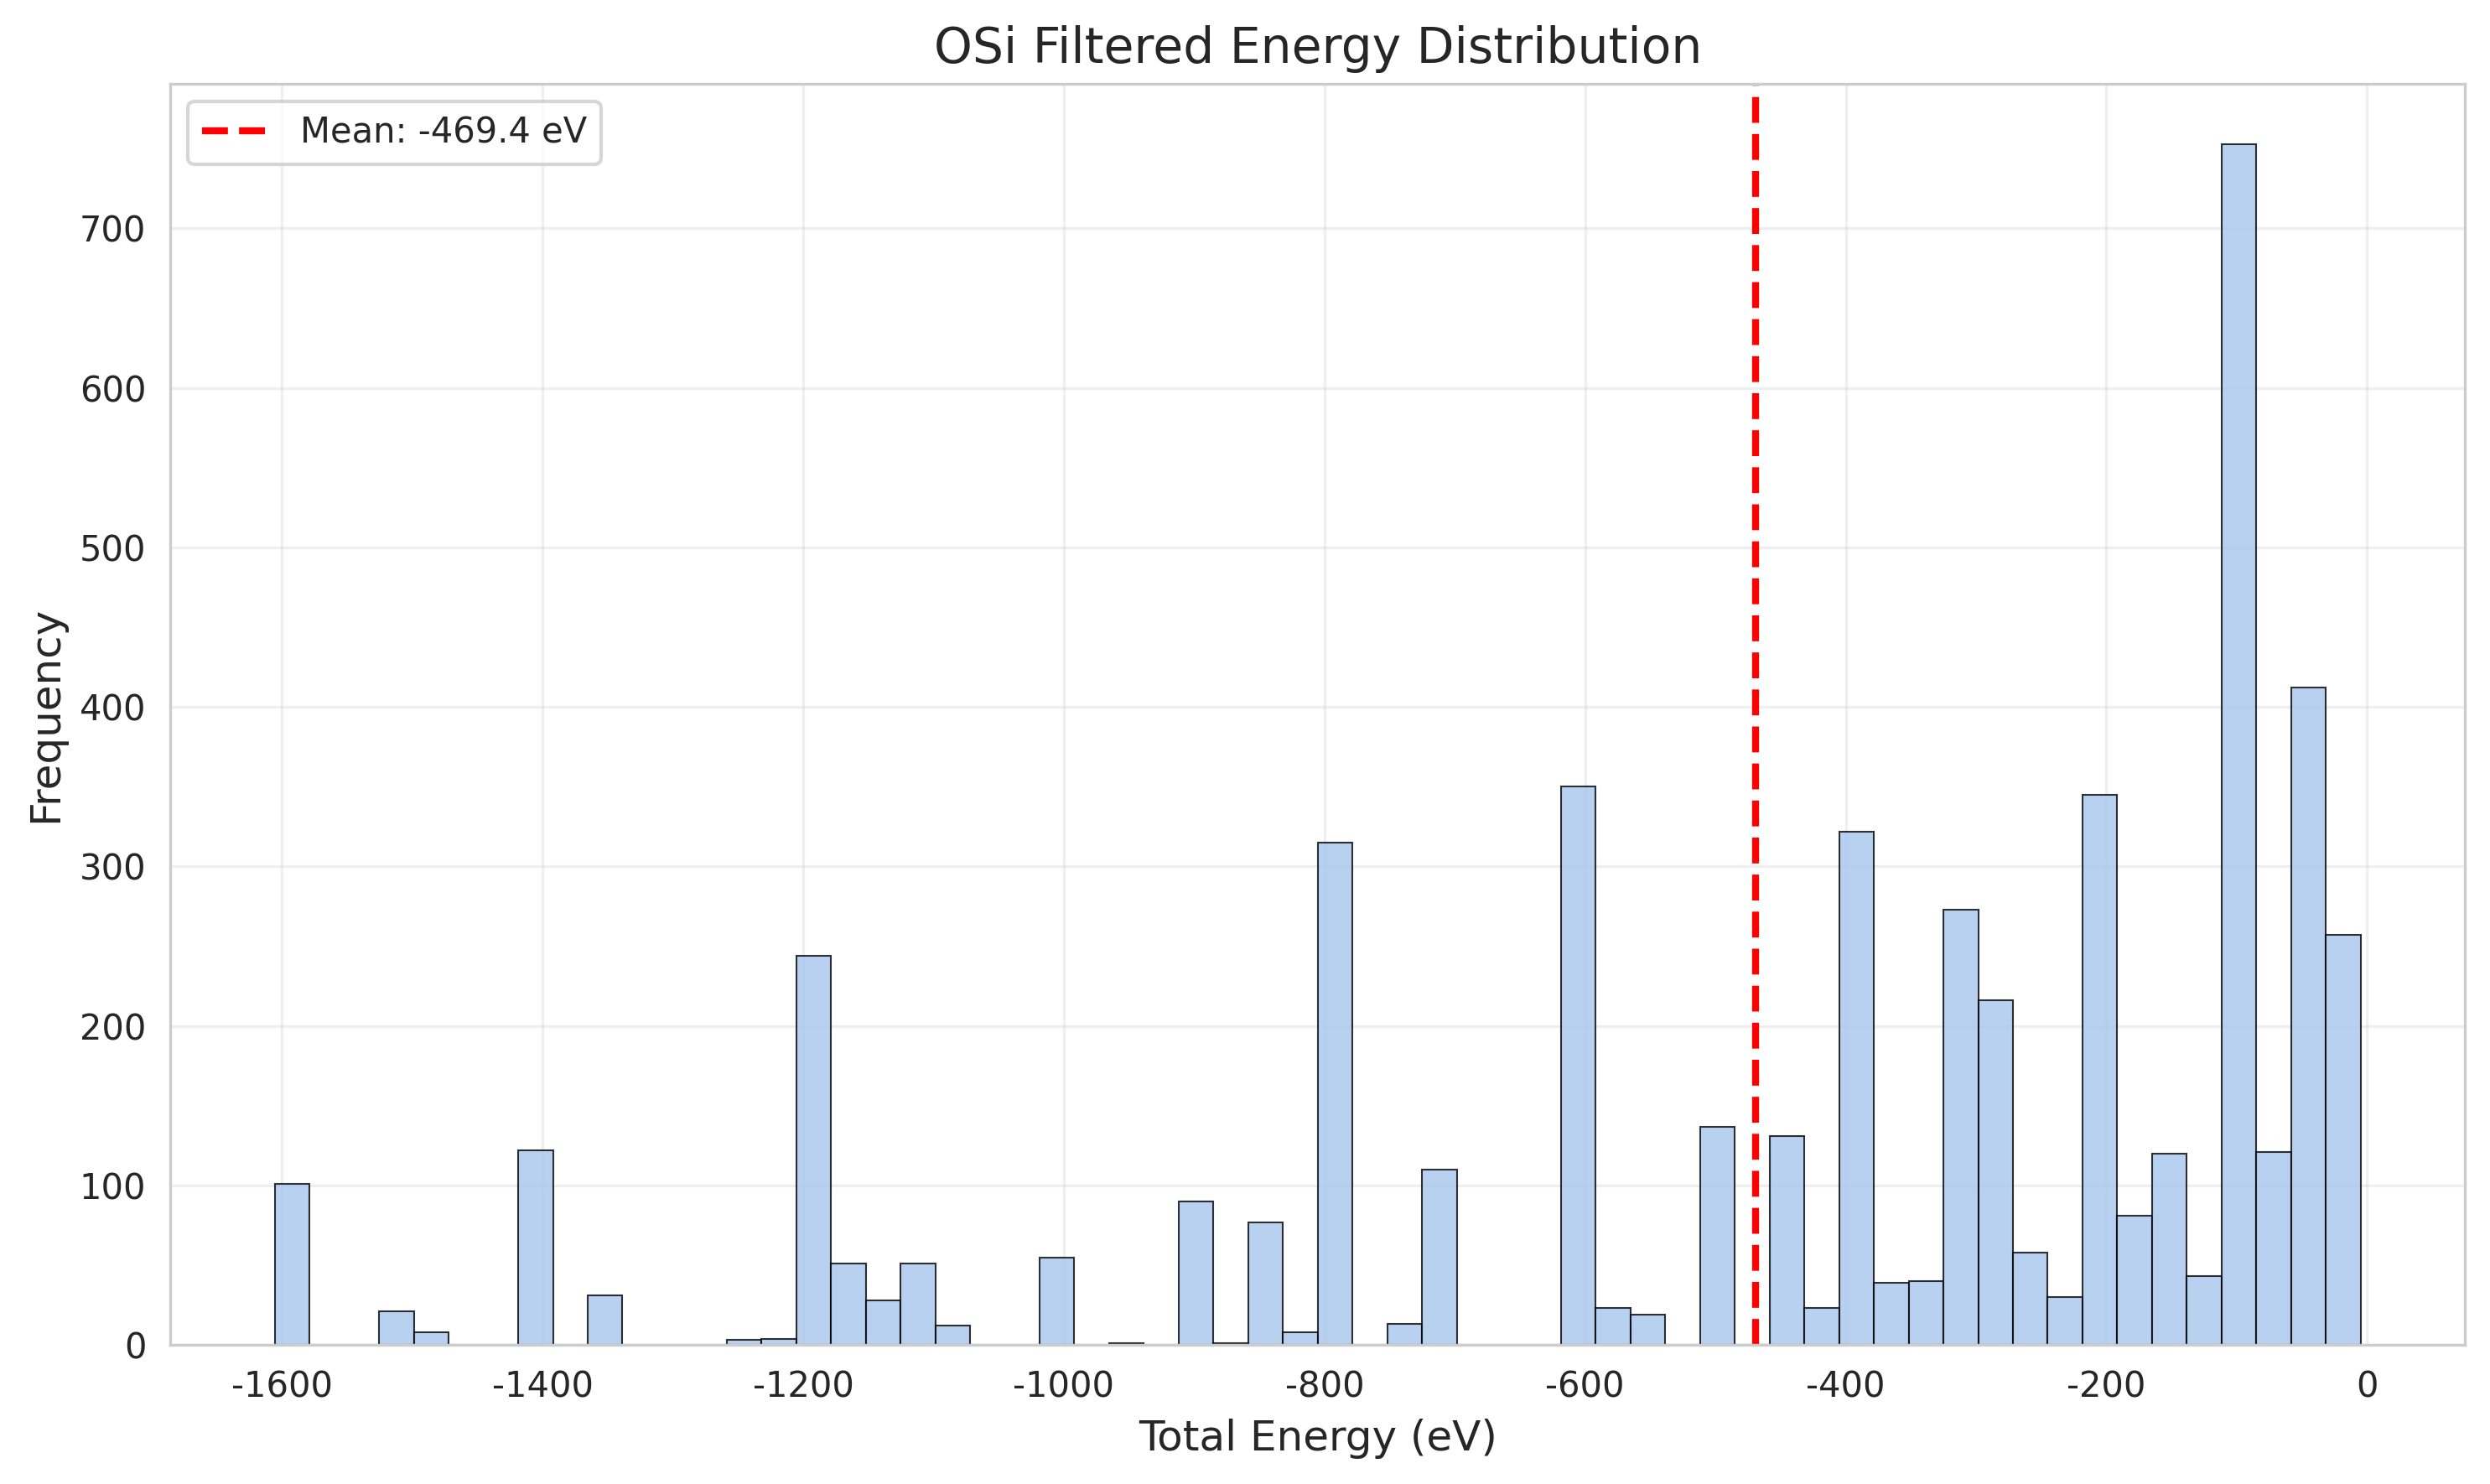

✓ Filtered energy distribution plot generated


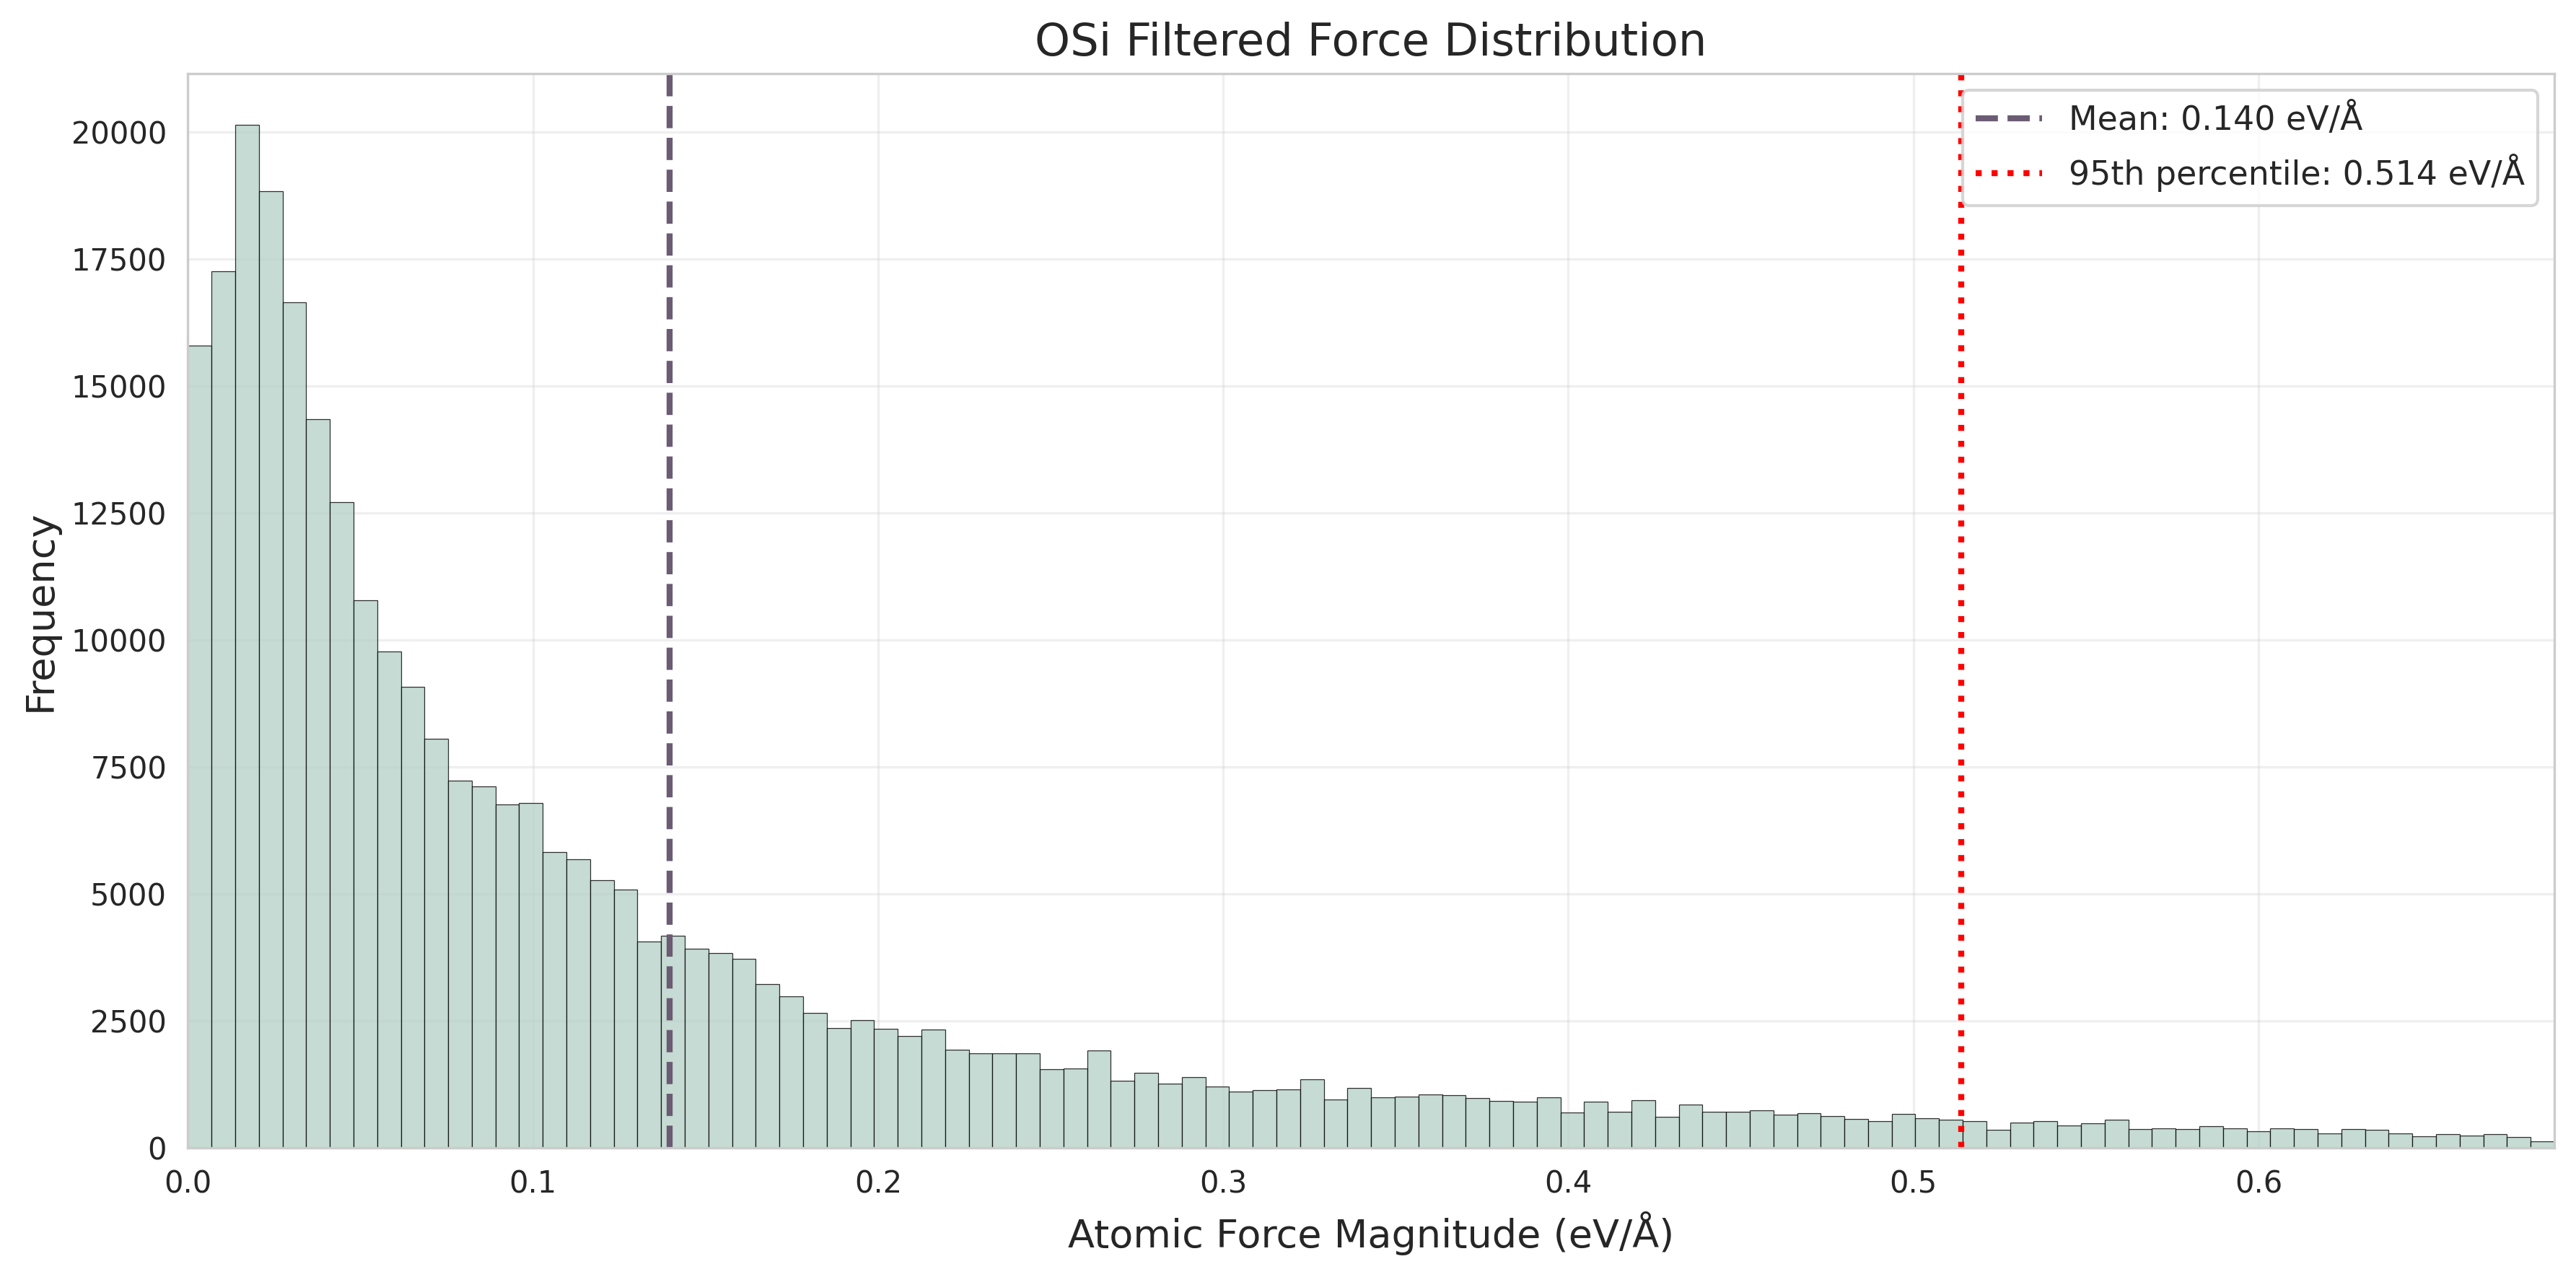

✓ Filtered force distribution plot generated

=== Filtered Force Statistics ===
Total atoms: 304,604
Mean force: 0.1396 eV/Å
95th percentile force: 0.5139 eV/Å
Max force: 1.0761 eV/Å
Very small force atoms (< 0.01 eV/Å): 7.6%
Converged atoms (< 0.05 eV/Å): 39.1%
× Poor structure quality after filtering, many atoms far from equilibrium


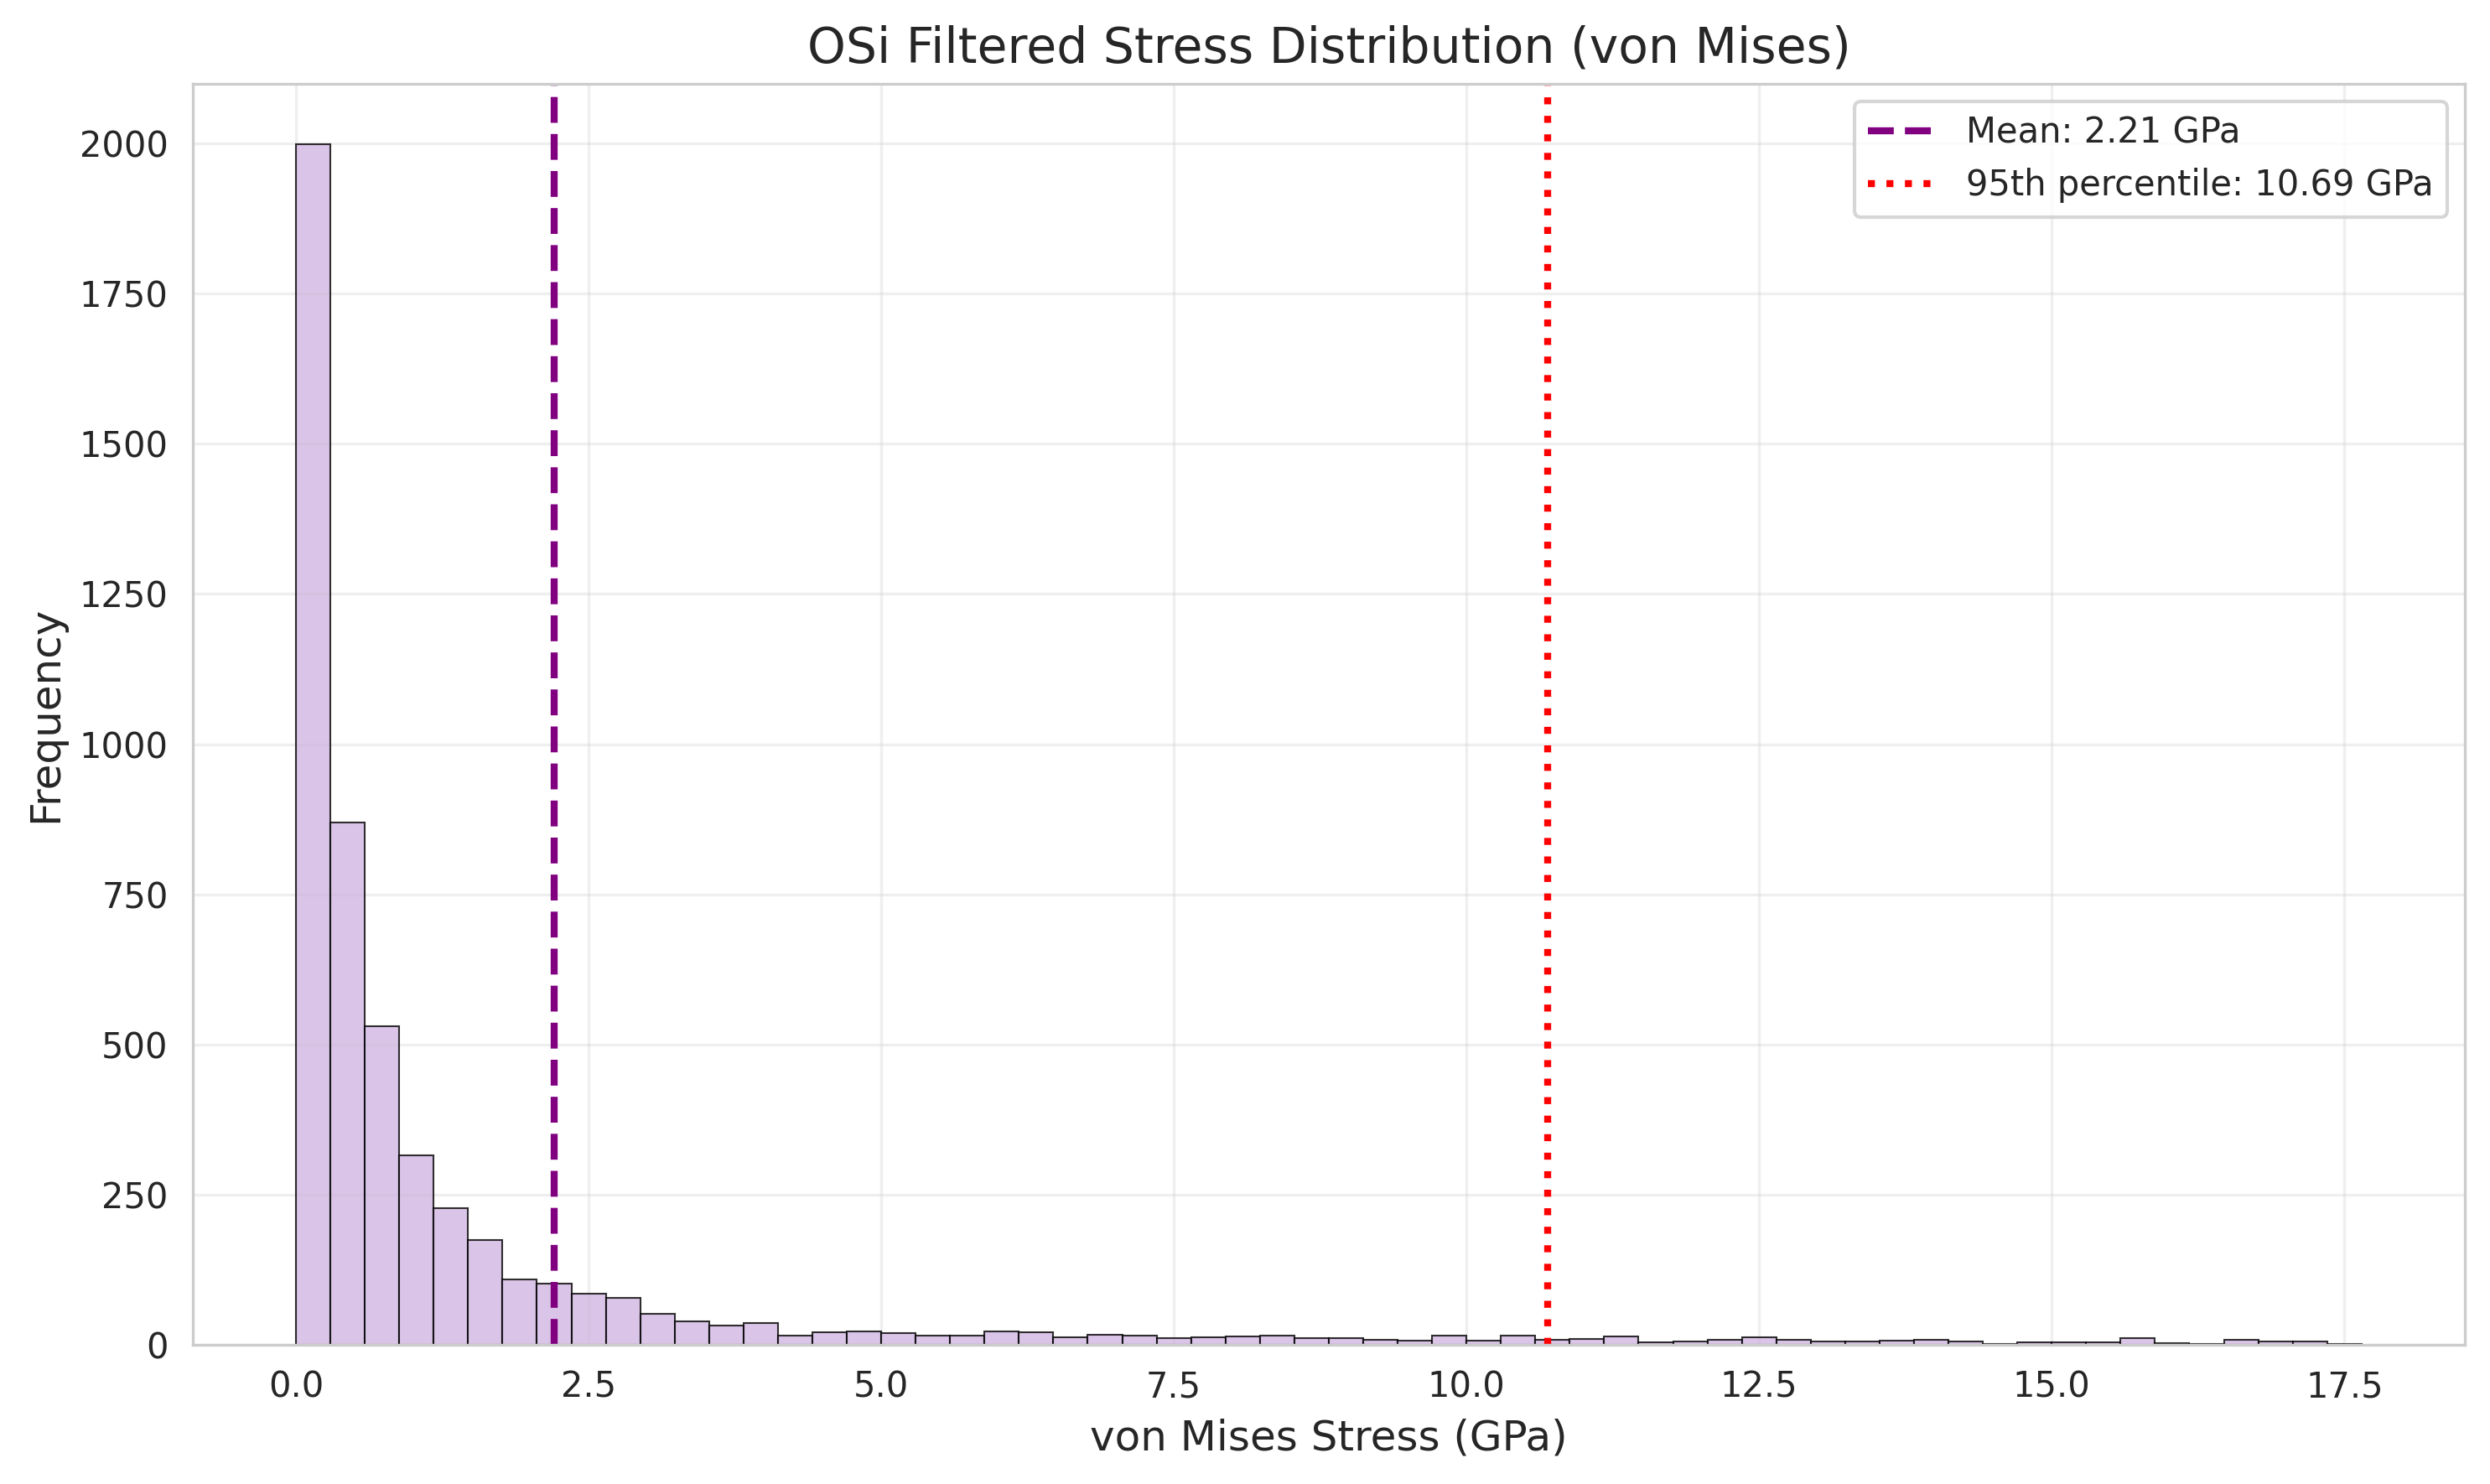

✓ Filtered stress distribution plot generated


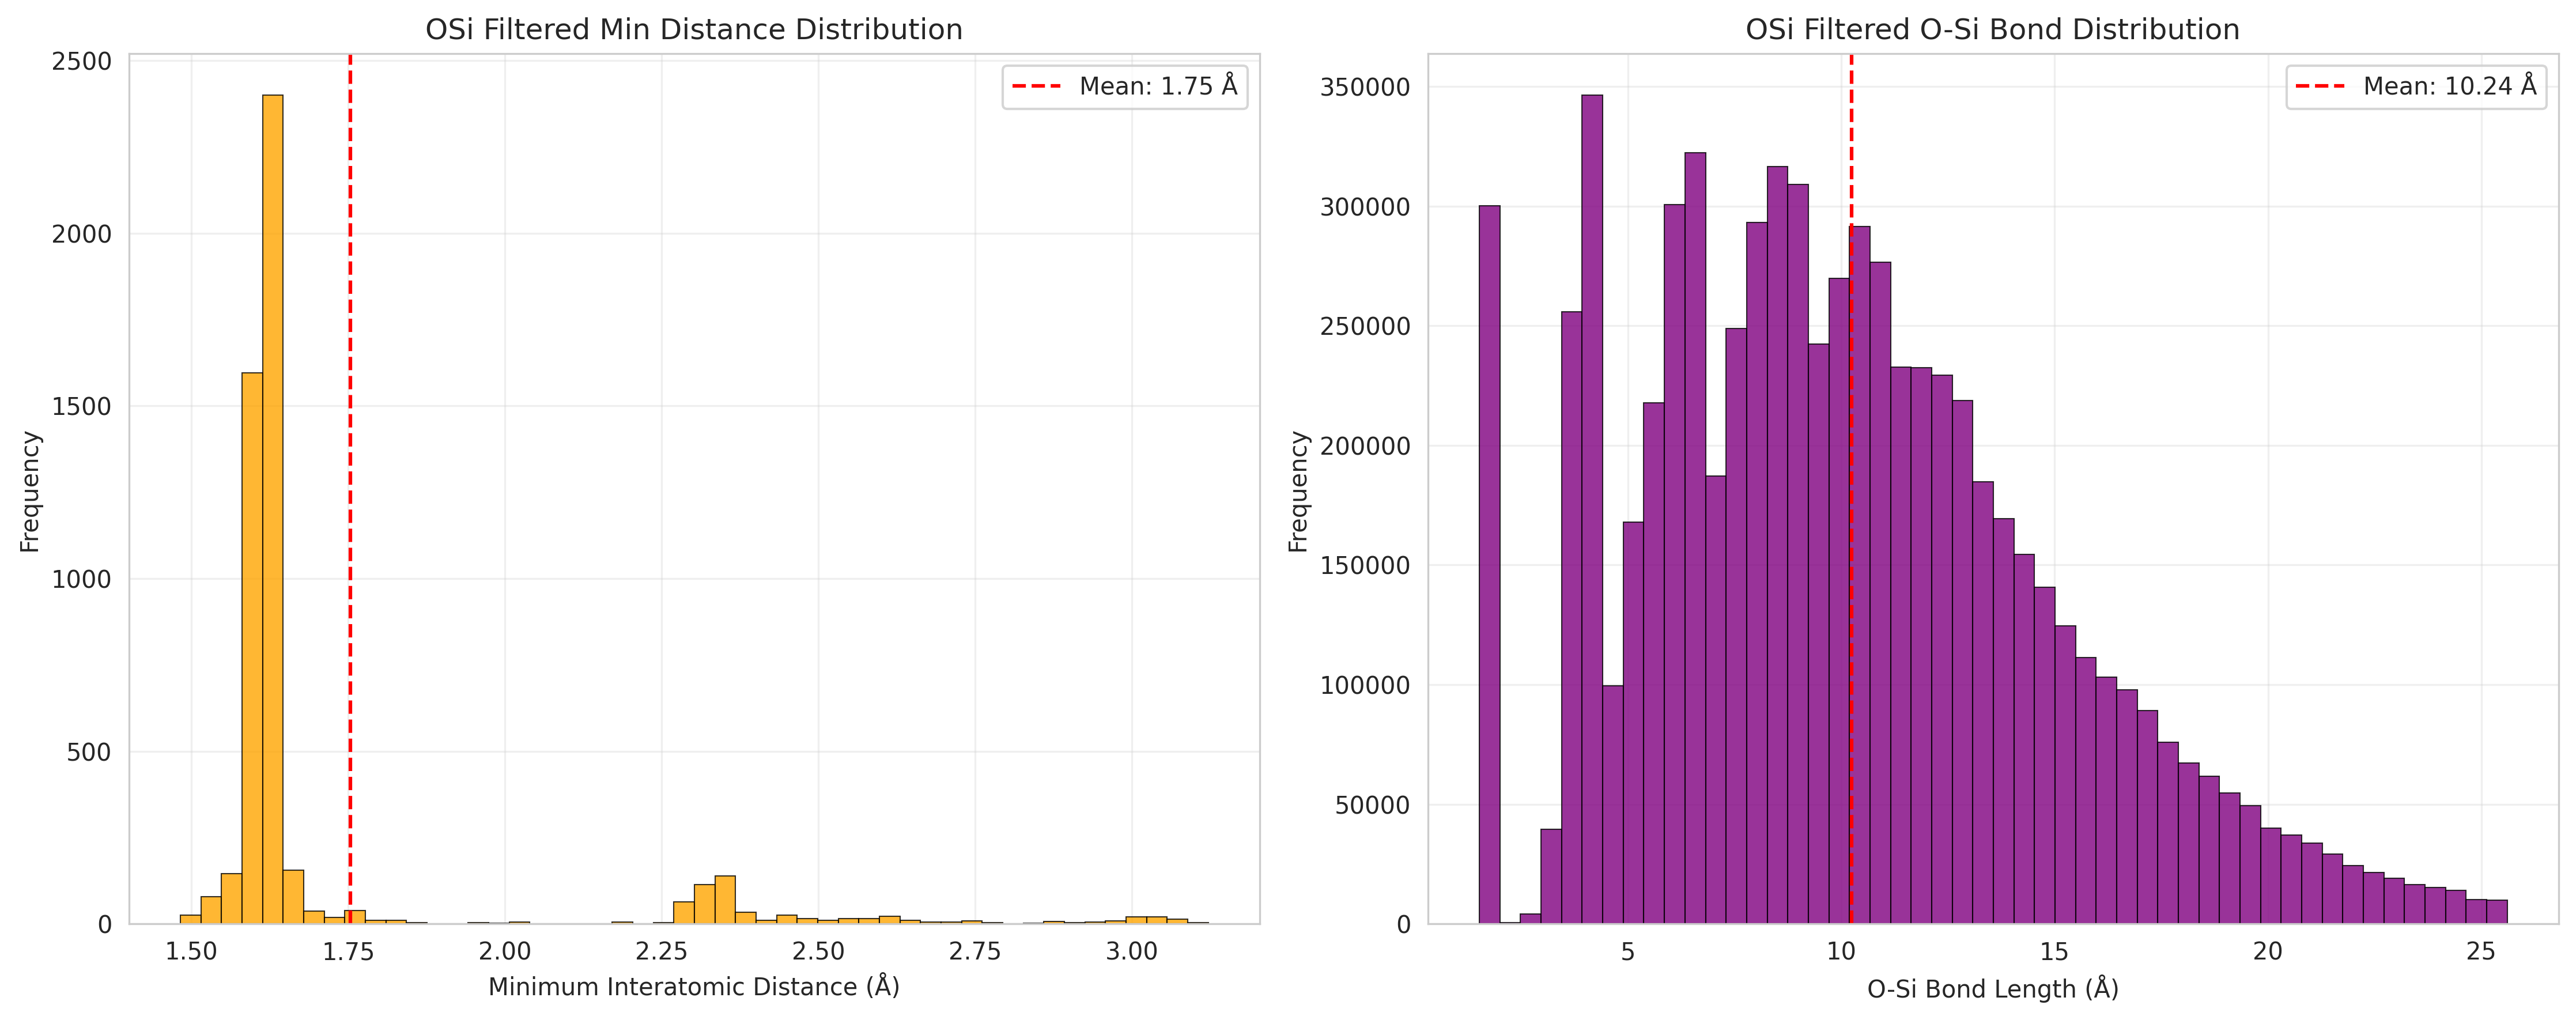

✓ Filtered geometry distribution plot generated
Filtered distribution plots saved to: OSi/filtered/distributions

=== Filtered Data Analysis Completed ===
Distribution plots saved to: OSi/filtered/distributions
Statistics report saved to: OSi/filtered/filtered_analysis.txt

Filtered data analysis completed! Please check the generated distribution plots and statistics report.


In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time

# 设置中文字体和绘图风格
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

def parse_structure_data(structure):
    """
    解析单个结构的详细数据
    """
    properties = structure['properties']
    species = structure['species']
    atoms_data = structure['atoms']
    
    # 解析能量
    energy = None
    if 'REF_energy' in properties:
        try:
            energy = float(properties['REF_energy'])
        except Exception as e:
            print(f"能量解析错误: {e}, 值: {properties['REF_energy']}")
            energy = None
    
    # 解析应力张量
    stress_tensor = None
    if 'REF_stress' in properties:
        try:
            stress_str = properties['REF_stress'].strip('"')
            stress_values = [float(x) for x in stress_str.split()]
            if len(stress_values) >= 6:
                # 应力张量：xx, yy, zz, xy, xz, yz
                stress_tensor = {
                    'xx': stress_values[0], 'yy': stress_values[1], 'zz': stress_values[2],
                    'xy': stress_values[3], 'xz': stress_values[4], 'yz': stress_values[5]
                }
        except Exception as e:
            print(f"应力解析错误: {e}")
            stress_tensor = None
    
    # 解析原子坐标和力
    positions = []
    forces = []
    for atom_line in atoms_data:
        parts = atom_line.split()
        if len(parts) >= 7:  # 元素 + 3坐标 + 3力
            try:
                pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                force = [float(parts[4]), float(parts[5]), float(parts[6])]
                positions.append(pos)
                forces.append(force)
            except:
                continue
    
    # 计算力的统计量
    force_magnitudes = []
    if forces:
        for force in forces:
            magnitude = np.sqrt(sum(f**2 for f in force))
            force_magnitudes.append(magnitude)
    
    # 计算几何特征
    geometry_stats = calculate_geometry_features(species, positions)
    
    return {
        'energy': energy,
        'energy_per_atom': energy / len(species) if energy and len(species) > 0 else None,
        'stress_tensor': stress_tensor,
        'forces': forces,
        'force_magnitudes': force_magnitudes,
        'max_force': max(force_magnitudes) if force_magnitudes else None,
        'avg_force': np.mean(force_magnitudes) if force_magnitudes else None,
        'positions': positions,
        'geometry': geometry_stats,
        'n_atoms': len(species),
        'composition': Counter(species)
    }

def calculate_geometry_features(species, positions):
    """
    计算几何特征：键长、原子间距等
    """
    if len(positions) < 2:
        return {'min_distance': None, 'bond_lengths': {}}
    
    positions = np.array(positions)
    n_atoms = len(positions)
    
    # 计算所有原子间距离
    distances = []
    bond_lengths = {}
    
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            dist = np.linalg.norm(positions[i] - positions[j])
            distances.append(dist)
            
            # 记录特定元素对的键长
            pair = tuple(sorted([species[i], species[j]]))
            if pair not in bond_lengths:
                bond_lengths[pair] = []
            bond_lengths[pair].append(dist)
    
    return {
        'min_distance': min(distances) if distances else None,
        'avg_distance': np.mean(distances) if distances else None,
        'bond_lengths': bond_lengths,
        'all_distances': distances
    }

def analyze_filtered_data(extxyz_file):
    """
    分析筛选后的数据，提取所有特征用于分布分析
    """
    print(f"=== Filtered Data Distribution Analysis ===")
    print(f"Analyzing file: {extxyz_file}")
    
    if not os.path.exists(extxyz_file):
        raise FileNotFoundError(f"文件不存在: {extxyz_file}")
    
    # 先用直接方法提取能量和应力数据
    print("Extracting energy and stress data using direct method...")
    energies = []
    stress_data = []
    
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        for line in f:
            # 提取能量
            if "REF_energy=" in line:
                for part in line.strip().split():
                    if part.startswith("REF_energy="):
                        try:
                            energy = float(part.split("=")[1])
                            energies.append(energy)
                            break
                        except:
                            pass
            
            # 提取应力
            if "REF_stress=" in line:
                try:
                    # 使用正则表达式提取引号内的应力数据
                    stress_match = re.search(r'REF_stress="([^"]*)"', line)
                    if stress_match:
                        stress_str = stress_match.group(1)
                        stress_values = [float(x) for x in stress_str.split()]
                        if len(stress_values) >= 6:
                            stress_data.append(stress_values)
                except:
                    pass
    
    print(f"Direct extraction results: {len(energies)} energy values, {len(stress_data)} stress tensors")
    
    # 提取所有原子的力数据
    print("Extracting atomic force data...")
    all_force_magnitudes = []
    
    # 存储所有分析数据
    analysis_data = {
        'energies': energies,  # 保存总能量
        'energies_per_atom': [],  # 也保留每原子能量以备用
        'all_force_magnitudes': [],  # 所有原子的力
        'max_forces': [],  # 每个结构的最大力
        'avg_forces': [],  # 每个结构的平均力
        'stress_xx': [s[0] for s in stress_data] if stress_data else [],
        'stress_yy': [s[1] for s in stress_data] if stress_data else [],
        'stress_zz': [s[2] for s in stress_data] if stress_data else [],
        'stress_xy': [s[3] for s in stress_data] if stress_data else [],
        'stress_xz': [s[4] for s in stress_data] if stress_data else [],
        'stress_yz': [s[5] for s in stress_data] if stress_data else [],
        'min_distances': [],
        'bond_lengths': {},
        'compositions': [],
        'n_atoms_list': []
    }
    
    structures_count = 0
    start_time = time.time()
    
    # 现在按结构解析来获取其他信息（力、几何等）
    with open(extxyz_file, 'r', encoding='utf-8') as f:
        while True:
            # 读取头部
            header_line = f.readline()
            if not header_line:
                break
            
            try:
                # 解析头部获取原子数
                n_atoms = int(header_line.strip().split()[0])
                
                # 获取对应的能量（如果有）
                current_energy = None
                if structures_count < len(energies):
                    current_energy = energies[structures_count]
                    # 计算每原子能量
                    energy_per_atom = current_energy / n_atoms if current_energy else None
                    if energy_per_atom:
                        analysis_data['energies_per_atom'].append(energy_per_atom)
                
                # 读取注释行
                comment_line = f.readline()
                
                # 读取原子数据并提取力
                atoms_data = []
                species = []
                structure_forces = []
                
                for _ in range(n_atoms):
                    atom_line = f.readline().strip()
                    if atom_line:
                        atoms_data.append(atom_line)
                        parts = atom_line.split()
                        if len(parts) >= 7:  # 元素 + 3坐标 + 3力
                            species.append(parts[0])
                            try:
                                # 提取力的三个分量
                                fx, fy, fz = float(parts[4]), float(parts[5]), float(parts[6])
                                force_magnitude = np.sqrt(fx**2 + fy**2 + fz**2)
                                structure_forces.append(force_magnitude)
                                all_force_magnitudes.append(force_magnitude)
                            except:
                                pass
                        else:
                            species.append(parts[0] if parts else 'X')
                
                # 计算这个结构的力统计
                if structure_forces:
                    analysis_data['max_forces'].append(max(structure_forces))
                    analysis_data['avg_forces'].append(np.mean(structure_forces))
                
                # 构建结构数据（仅用于解析几何）
                structure = {
                    'properties': {},  # 不需要重复解析
                    'species': species,
                    'atoms': atoms_data
                }
                
                # 解析几何特征
                positions = []
                for atom_line in atoms_data:
                    parts = atom_line.split()
                    if len(parts) >= 4:  # 至少有坐标
                        try:
                            pos = [float(parts[1]), float(parts[2]), float(parts[3])]
                            positions.append(pos)
                        except:
                            continue
                
                # 计算几何特征
                if len(positions) >= 2:
                    geometry_stats = calculate_geometry_features(species, positions)
                    if geometry_stats['min_distance']:
                        analysis_data['min_distances'].append(geometry_stats['min_distance'])
                    
                    # 键长数据
                    for bond_type, lengths in geometry_stats['bond_lengths'].items():
                        if bond_type not in analysis_data['bond_lengths']:
                            analysis_data['bond_lengths'][bond_type] = []
                        analysis_data['bond_lengths'][bond_type].extend(lengths)
                
                analysis_data['n_atoms_list'].append(len(species))
                analysis_data['compositions'].append(Counter(species))
                
                structures_count += 1
                
                if structures_count % 1000 == 0:
                    elapsed = time.time() - start_time
                    print(f"Analyzed: {structures_count:,} structures, time: {elapsed:.1f}s")
                    
            except Exception as e:
                print(f"Error analyzing structure {structures_count+1}: {e}")
                continue
    
    # 保存所有原子的力数据
    analysis_data['all_force_magnitudes'] = all_force_magnitudes
    
    print(f"Analysis completed: {structures_count:,} structures total")
    print(f"Extracted {len(all_force_magnitudes):,} atomic force data")
    return analysis_data

def create_distribution_plots(analysis_data, element_system, save_dir):
    """
    创建筛选后数据分布图
    """
    print("Generating filtered data distribution plots...")
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 调试信息：检查数据状态
    print(f"Debug info:")
    print(f"  Total energy data: {len(analysis_data['energies'])}")
    print(f"  Atomic force data: {len(analysis_data['all_force_magnitudes'])}")
    print(f"  Structure max force data: {len(analysis_data['max_forces'])}")
    print(f"  Stress data: {len(analysis_data['stress_xx'])}")
    print(f"  Geometry data: {len(analysis_data['min_distances'])}")
    
    # 1. 能量分布图
    if analysis_data['energies']:
        plt.figure(figsize=(10, 6))
        
        energies = np.array(analysis_data['energies'])
        
        # 计算合理的显示范围（去掉极端异常值）
        q1, q99 = np.percentile(energies, [1, 99])
        mask = (energies >= q1) & (energies <= q99)
        energies_filtered = energies[mask]
        
        plt.hist(energies_filtered, bins=60, alpha=0.8, color='#A7C6ED', edgecolor='black', linewidth=0.5)
        plt.xlabel('Total Energy (eV)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'{element_system} Filtered Energy Distribution', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_e = np.mean(energies)
        plt.axvline(mean_e, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_e:.1f} eV')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'energy_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Filtered energy distribution plot generated")
    else:
        print("⚠️  Warning: No energy data found, skipping energy distribution plot")
    
    # 2. 力分布图 - 清晰的原子力分布
    if analysis_data['all_force_magnitudes']:
        plt.figure(figsize=(12, 6))
        
        all_forces = np.array(analysis_data['all_force_magnitudes'])
        
        # 设置合理的显示范围（去掉极端值，聚焦主要分布）
        force_limit = min(2.0, np.percentile(all_forces, 98))  # 98分位数或2.0 eV/Å
        mask = all_forces <= force_limit
        forces_filtered = all_forces[mask]
        
        # 绘制直方图
        plt.hist(forces_filtered, bins=100, alpha=0.8, color='#B7D2C8', 
                edgecolor='black', linewidth=0.3)
        plt.xlabel('Atomic Force Magnitude (eV/Å)', fontsize=13)
        plt.ylabel('Frequency', fontsize=13)
        plt.title(f'{element_system} Filtered Force Distribution', fontsize=15)
        plt.grid(True, alpha=0.3)
        
        # 添加统计线
        mean_force = np.mean(all_forces)
        p95_force = np.percentile(all_forces, 95)
        plt.axvline(mean_force, color='#6B5B73', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_force:.3f} eV/Å')
        plt.axvline(p95_force, color='red', linestyle=':', linewidth=2,
                   label=f'95th percentile: {p95_force:.3f} eV/Å')
        plt.legend(fontsize=11)
        
        # 设置x轴范围
        plt.xlim(0, force_limit)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'force_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Filtered force distribution plot generated")
        
        # 打印统计信息
        print(f"\n=== Filtered Force Statistics ===")
        print(f"Total atoms: {len(all_forces):,}")
        print(f"Mean force: {mean_force:.4f} eV/Å")
        print(f"95th percentile force: {p95_force:.4f} eV/Å")
        print(f"Max force: {np.max(all_forces):.4f} eV/Å")
        
        small_force = np.sum(all_forces < 0.01) / len(all_forces) * 100
        converged = np.sum(all_forces < 0.05) / len(all_forces) * 100
        print(f"Very small force atoms (< 0.01 eV/Å): {small_force:.1f}%")
        print(f"Converged atoms (< 0.05 eV/Å): {converged:.1f}%")
        
        if mean_force < 0.05:
            print("✓ Excellent structure quality after filtering, most atoms near equilibrium")
        elif mean_force < 0.1:
            print("△ Good structure quality after filtering, some atoms still adjusting")
        else:
            print("× Poor structure quality after filtering, many atoms far from equilibrium")
        
    else:
        print("⚠️  Warning: No force data found, skipping force distribution plot")
    
    # 3. 应力分布图 - 转换为标量
    if any(analysis_data[comp] for comp in ['stress_xx', 'stress_yy', 'stress_zz']):
        plt.figure(figsize=(10, 6))
        
        # 计算应力标量（von Mises等效应力）
        stress_scalars = []
        for i in range(len(analysis_data['stress_xx'])):
            # 获取应力张量的对角线元素
            sxx = analysis_data['stress_xx'][i]
            syy = analysis_data['stress_yy'][i] 
            szz = analysis_data['stress_zz'][i]
            sxy = analysis_data['stress_xy'][i] if analysis_data['stress_xy'] else 0
            sxz = analysis_data['stress_xz'][i] if analysis_data['stress_xz'] else 0
            syz = analysis_data['stress_yz'][i] if analysis_data['stress_yz'] else 0
            
            # 计算von Mises等效应力
            von_mises = np.sqrt(0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2 + 
                                      6 * (sxy**2 + sxz**2 + syz**2)))
            stress_scalars.append(von_mises)
        
        stress_scalars = np.array(stress_scalars)
        
        # 设置合理的显示范围
        stress_limit = np.percentile(stress_scalars, 98)
        mask = stress_scalars <= stress_limit
        stress_filtered = stress_scalars[mask]
        
        plt.hist(stress_filtered, bins=60, alpha=0.8, color='#D1B6E1', edgecolor='black', linewidth=0.5)
        plt.xlabel('von Mises Stress (GPa)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'{element_system} Filtered Stress Distribution (von Mises)', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # 添加统计线
        mean_stress = np.mean(stress_scalars)
        p95_stress = np.percentile(stress_scalars, 95)
        plt.axvline(mean_stress, color='purple', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_stress:.2f} GPa')
        plt.axvline(p95_stress, color='red', linestyle=':', linewidth=2,
                   label=f'95th percentile: {p95_stress:.2f} GPa')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'stress_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Filtered stress distribution plot generated")
    else:
        print("⚠️  Warning: No stress data found, skipping stress distribution plot")
    
    # 4. 几何特征分布图 - 简化为2个关键图
    if analysis_data['bond_lengths'] or analysis_data['min_distances']:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # 左图：最小原子间距
        if analysis_data['min_distances']:
            min_dists = np.array(analysis_data['min_distances'])
            # 设置合理范围
            dist_limit = np.percentile(min_dists, 99)
            mask = min_dists <= dist_limit
            dists_filtered = min_dists[mask]
            
            axes[0].hist(dists_filtered, bins=50, alpha=0.8, color='orange', edgecolor='black', linewidth=0.5)
            axes[0].set_xlabel('Minimum Interatomic Distance (Å)')
            axes[0].set_ylabel('Frequency')
            axes[0].set_title(f'{element_system} Filtered Min Distance Distribution')
            axes[0].grid(True, alpha=0.3)
            
            # 添加统计线
            mean_dist = np.mean(min_dists)
            axes[0].axvline(mean_dist, color='red', linestyle='--', 
                           label=f'Mean: {mean_dist:.2f} Å')
            axes[0].legend()
        
        # 右图：主要键长分布（选择样本数最多的键型）
        if analysis_data['bond_lengths']:
            # 找到样本数最多的键型
            main_bond = max(analysis_data['bond_lengths'].items(), key=lambda x: len(x[1]))
            bond_type, bond_lengths = main_bond
            
            if len(bond_lengths) > 100:  # 只有足够样本才显示
                bond_lengths = np.array(bond_lengths)
                bond_limit = np.percentile(bond_lengths, 99)
                mask = bond_lengths <= bond_limit
                bonds_filtered = bond_lengths[mask]
                
                axes[1].hist(bonds_filtered, bins=50, alpha=0.8, color='purple', 
                           edgecolor='black', linewidth=0.5)
                axes[1].set_xlabel(f'{bond_type[0]}-{bond_type[1]} Bond Length (Å)')
                axes[1].set_ylabel('Frequency')
                axes[1].set_title(f'{element_system} Filtered {bond_type[0]}-{bond_type[1]} Bond Distribution')
                axes[1].grid(True, alpha=0.3)
                
                # 添加统计线
                mean_bond = np.mean(bond_lengths)
                axes[1].axvline(mean_bond, color='red', linestyle='--',
                               label=f'Mean: {mean_bond:.2f} Å')
                axes[1].legend()
            else:
                axes[1].text(0.5, 0.5, 'No sufficient bond data', 
                           transform=axes[1].transAxes, ha='center', va='center')
                axes[1].set_title('Bond Length Distribution')
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'geometry_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Filtered geometry distribution plot generated")
    
    print(f"Filtered distribution plots saved to: {save_dir}")

def generate_statistics_summary(analysis_data, element_system, save_file):
    """
    生成筛选后数据的详细统计摘要
    """
    with open(save_file, 'w', encoding='utf-8') as f:
        f.write(f"=== {element_system} 筛选后数据分布分析报告 ===\n")
        f.write(f"分析时间: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # 总体数据量
        f.write("【数据概况】\n")
        f.write(f"  筛选后结构数量: {len(analysis_data['energies']):,}\n")
        f.write(f"  筛选后原子总数: {len(analysis_data['all_force_magnitudes']):,}\n")
        f.write(f"  平均每结构原子数: {len(analysis_data['all_force_magnitudes'])/len(analysis_data['energies']):.1f}\n\n")
        
        # 能量统计
        if analysis_data['energies']:
            energies = np.array(analysis_data['energies'])
            f.write("【能量统计】\n")
            f.write(f"  样本数量: {len(energies):,}\n")
            f.write(f"  平均值: {np.mean(energies):.6f} eV\n")
            f.write(f"  标准差: {np.std(energies):.6f} eV\n")
            f.write(f"  最小值: {np.min(energies):.6f} eV\n")
            f.write(f"  最大值: {np.max(energies):.6f} eV\n\n")
        
        # 力统计
        if analysis_data['all_force_magnitudes']:
            all_forces = np.array(analysis_data['all_force_magnitudes'])
            max_forces = np.array(analysis_data['max_forces'])
            f.write("【力统计】\n")
            f.write(f"  原子力统计:\n")
            f.write(f"    总原子数: {len(all_forces):,}\n")
            f.write(f"    平均力: {np.mean(all_forces):.4f} eV/Å\n")
            f.write(f"    标准差: {np.std(all_forces):.4f} eV/Å\n")
            f.write(f"    95分位数: {np.percentile(all_forces, 95):.4f} eV/Å\n")
            f.write(f"    最大力: {np.max(all_forces):.4f} eV/Å\n")
            
            f.write(f"  结构最大力统计:\n")
            f.write(f"    平均值: {np.mean(max_forces):.4f} eV/Å\n")
            f.write(f"    标准差: {np.std(max_forces):.4f} eV/Å\n")
            f.write(f"    95分位数: {np.percentile(max_forces, 95):.4f} eV/Å\n\n")
            
            # 收敛性分析
            small_force = np.sum(all_forces < 0.01) / len(all_forces) * 100
            converged = np.sum(all_forces < 0.05) / len(all_forces) * 100
            f.write(f"  收敛性分析:\n")
            f.write(f"    极小力原子 (< 0.01 eV/Å): {small_force:.1f}%\n")
            f.write(f"    收敛原子 (< 0.05 eV/Å): {converged:.1f}%\n\n")
        
        # 应力统计
        if analysis_data['stress_xx']:
            stress_scalars = []
            for i in range(len(analysis_data['stress_xx'])):
                sxx = analysis_data['stress_xx'][i]
                syy = analysis_data['stress_yy'][i] 
                szz = analysis_data['stress_zz'][i]
                sxy = analysis_data['stress_xy'][i] if analysis_data['stress_xy'] else 0
                sxz = analysis_data['stress_xz'][i] if analysis_data['stress_xz'] else 0
                syz = analysis_data['stress_yz'][i] if analysis_data['stress_yz'] else 0
                
                von_mises = np.sqrt(0.5 * ((sxx - syy)**2 + (syy - szz)**2 + (szz - sxx)**2 + 
                                          6 * (sxy**2 + sxz**2 + syz**2)))
                stress_scalars.append(von_mises)
            
            stress_scalars = np.array(stress_scalars)
            f.write("【应力统计】\n")
            f.write(f"  von Mises应力:\n")
            f.write(f"    样本数量: {len(stress_scalars):,}\n")
            f.write(f"    平均值: {np.mean(stress_scalars):.6f} GPa\n")
            f.write(f"    标准差: {np.std(stress_scalars):.6f} GPa\n")
            f.write(f"    范围: [{np.min(stress_scalars):.6f}, {np.max(stress_scalars):.6f}] GPa\n\n")
        
        # 几何统计
        if analysis_data['min_distances']:
            min_dists = np.array(analysis_data['min_distances'])
            f.write("【几何特征统计】\n")
            f.write(f"  最小原子间距:\n")
            f.write(f"    平均值: {np.mean(min_dists):.4f} Å\n")
            f.write(f"    最小值: {np.min(min_dists):.4f} Å\n")
            f.write(f"    标准差: {np.std(min_dists):.4f} Å\n")
            f.write(f"    5分位数: {np.percentile(min_dists, 5):.4f} Å\n\n")
        
        # 键长统计
        if analysis_data['bond_lengths']:
            f.write("【键长分布统计】\n")
            for bond_type, lengths in analysis_data['bond_lengths'].items():
                if len(lengths) > 10:  # 只显示样本数足够的键型
                    lengths_array = np.array(lengths)
                    f.write(f"  {bond_type[0]}-{bond_type[1]} 键:\n")
                    f.write(f"    样本数: {len(lengths):,}\n")
                    f.write(f"    平均键长: {np.mean(lengths_array):.4f} Å\n")
                    f.write(f"    标准差: {np.std(lengths_array):.4f} Å\n")
                    f.write(f"    范围: [{np.min(lengths_array):.4f}, {np.max(lengths_array):.4f}] Å\n")
            f.write("\n")
        
        # MACE训练评估
        f.write("【MACE训练评估】\n")
        f.write(f"✓ 筛选后数据质量评估:\n")
        
        if analysis_data['all_force_magnitudes']:
            mean_force = np.mean(np.array(analysis_data['all_force_magnitudes']))
            if mean_force < 0.05:
                f.write(f"  - 力质量: 优秀 (平均力 {mean_force:.3f} eV/Å < 0.05)\n")
            elif mean_force < 0.1:
                f.write(f"  - 力质量: 良好 (平均力 {mean_force:.3f} eV/Å < 0.1)\n")
            else:
                f.write(f"  - 力质量: 一般 (平均力 {mean_force:.3f} eV/Å)\n")
        
        if analysis_data['energies']:
            energy_std = np.std(np.array(analysis_data['energies']))
            f.write(f"  - 能量稳定性: 标准差 {energy_std:.3f} eV\n")
        
        f.write(f"\n✓ 训练建议:\n")
        f.write(f"  - 数据集大小: {len(analysis_data['energies']):,} 个结构适合MACE训练\n")
        f.write(f"  - 建议训练/测试比例: 80/20\n")
        f.write(f"  - 推荐max_num_neighbors: 基于几何分析确定\n")
        f.write(f"  - 数据质量: 筛选后数据质量显著提升，适合高精度势函数训练\n")

def step4_analyze_filtered_data(extxyz_file):
    """
    第四步主函数：筛选后数据分布分析
    
    参数:
    extxyz_file: 第三步输出的筛选数据文件路径
    
    返回:
    analysis_data: 分析数据
    statistics_file: 统计报告文件路径
    """
    # 确定元素体系和保存路径
    base_dir = os.path.dirname(os.path.dirname(extxyz_file))  # 去掉/filtered部分
    element_system = os.path.basename(base_dir)
    distributions_dir = os.path.join(os.path.dirname(extxyz_file), 'distributions')
    
    try:
        # 分析筛选后数据
        analysis_data = analyze_filtered_data(extxyz_file)
        
        # 生成分布图
        create_distribution_plots(analysis_data, element_system, distributions_dir)
        
        # 生成统计报告
        stats_file = os.path.join(os.path.dirname(extxyz_file), 'filtered_analysis.txt')
        generate_statistics_summary(analysis_data, element_system, stats_file)
        
        print(f"\n=== Filtered Data Analysis Completed ===")
        print(f"Distribution plots saved to: {distributions_dir}")
        print(f"Statistics report saved to: {stats_file}")
        
        return analysis_data, stats_file
        
    except Exception as e:
        print(f"Error during filtered data analysis: {e}")
        raise

# 使用示例
if __name__ == "__main__":
    # 示例调用（假设第三步已完成）
    extxyz_file = "OSi/filtered/OSi_filtered.extxyz"  # 第三步的输出文件
    
    analysis_data, stats_file = step4_analyze_filtered_data(extxyz_file)
    print(f"\nFiltered data analysis completed! Please check the generated distribution plots and statistics report.")